## Name : Amruta Mulay , Github Username : Amruta131198 , USC ID : 6897885438

In [1]:
#Importing all necessary libraries required for HW-4
import os
import re
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

COLUMN_NAMES = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
OG_COLUMN_NAMES = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['Mean', 'STD', 'Min', '1st_quartile', 'Median', '3rd_quartile', 'Max']
ORDERED_STATS = ['Min', 'Max', 'Mean', 'Median', 'STD', '1st_quartile', '3rd_quartile']

### Time Series Classification Part 1: Feature Creation/Extraction

### 1. (a) Download the AReM Dataset

In [2]:
ROOT = '../data/'
sniffer = csv.Sniffer()

### 1. (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data

In [3]:
#Reference: os.walk(): https://www.tutorialspoint.com/python/os_walk.htm

# os.path.split() method in Python is used to Split the path name into a pair head[0] and tail[1].
#Here, tail is the last path name component and head is everything leading up to that.
# os.path.splitext() is used to split the path name into a pair root and extension.

# function to traverse data folder and split file paths in to train group and test group
def split_train_test(root):
    train_set = []
    test_set = []
    for root, _, file in os.walk(root):
        for f in file:
            if (os.path.splitext(f)[1] == ".csv"):
                # find digits (database1.csv, database2.csv , ...)
                csv_idx = int(re.findall("\d+", f)[0])
                file_path = os.path.join(root, f)
                activity = os.path.split(root)[-1]
                if (csv_idx <= 2 or (activity not in ["bending1", "bending2"] and csv_idx == 3)):
                    test_set.append(file_path)
                else:
                    train_set.append(file_path)
    return train_set, test_set

In [4]:
# Splitting data in test set and training set
train, test = split_train_test(ROOT)

In [5]:
train

['../data/bending1/dataset7.csv',
 '../data/bending1/dataset6.csv',
 '../data/bending1/dataset4.csv',
 '../data/bending1/dataset5.csv',
 '../data/bending1/dataset3.csv',
 '../data/walking/dataset7.csv',
 '../data/walking/dataset6.csv',
 '../data/walking/dataset4.csv',
 '../data/walking/dataset5.csv',
 '../data/walking/dataset10.csv',
 '../data/walking/dataset11.csv',
 '../data/walking/dataset13.csv',
 '../data/walking/dataset12.csv',
 '../data/walking/dataset15.csv',
 '../data/walking/dataset14.csv',
 '../data/walking/dataset8.csv',
 '../data/walking/dataset9.csv',
 '../data/bending2/dataset6.csv',
 '../data/bending2/dataset4.csv',
 '../data/bending2/dataset5.csv',
 '../data/bending2/dataset3.csv',
 '../data/standing/dataset7.csv',
 '../data/standing/dataset6.csv',
 '../data/standing/dataset4.csv',
 '../data/standing/dataset5.csv',
 '../data/standing/dataset10.csv',
 '../data/standing/dataset11.csv',
 '../data/standing/dataset13.csv',
 '../data/standing/dataset12.csv',
 '../data/standi

In [6]:
test

['../data/bending1/dataset1.csv',
 '../data/bending1/dataset2.csv',
 '../data/walking/dataset1.csv',
 '../data/walking/dataset2.csv',
 '../data/walking/dataset3.csv',
 '../data/bending2/dataset1.csv',
 '../data/bending2/dataset2.csv',
 '../data/standing/dataset1.csv',
 '../data/standing/dataset2.csv',
 '../data/standing/dataset3.csv',
 '../data/sitting/dataset1.csv',
 '../data/sitting/dataset2.csv',
 '../data/sitting/dataset3.csv',
 '../data/lying/dataset1.csv',
 '../data/lying/dataset2.csv',
 '../data/lying/dataset3.csv',
 '../data/cycling/dataset1.csv',
 '../data/cycling/dataset2.csv',
 '../data/cycling/dataset3.csv']

In [7]:
entire_dataset = train + test
entire_dataset

['../data/bending1/dataset7.csv',
 '../data/bending1/dataset6.csv',
 '../data/bending1/dataset4.csv',
 '../data/bending1/dataset5.csv',
 '../data/bending1/dataset3.csv',
 '../data/walking/dataset7.csv',
 '../data/walking/dataset6.csv',
 '../data/walking/dataset4.csv',
 '../data/walking/dataset5.csv',
 '../data/walking/dataset10.csv',
 '../data/walking/dataset11.csv',
 '../data/walking/dataset13.csv',
 '../data/walking/dataset12.csv',
 '../data/walking/dataset15.csv',
 '../data/walking/dataset14.csv',
 '../data/walking/dataset8.csv',
 '../data/walking/dataset9.csv',
 '../data/bending2/dataset6.csv',
 '../data/bending2/dataset4.csv',
 '../data/bending2/dataset5.csv',
 '../data/bending2/dataset3.csv',
 '../data/standing/dataset7.csv',
 '../data/standing/dataset6.csv',
 '../data/standing/dataset4.csv',
 '../data/standing/dataset5.csv',
 '../data/standing/dataset10.csv',
 '../data/standing/dataset11.csv',
 '../data/standing/dataset13.csv',
 '../data/standing/dataset12.csv',
 '../data/standi

### 1.(c) Feature Extraction

### 1.(c-i) Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

> ANSWER:
>##### Time series classification involves analyzing and classifying sequences of data points over time. To do this, various time-domain features are commonly used to extract meaningful information from the time series data. These features capture different aspects of the data's distribution and behavior. Here are some of the commonly used time-domain features in time series classification:

>- Mean: The average value of the data points in the time series.

>- Median: The middle value of the data points when they are sorted in ascending order. It is less sensitive to outliers compared to the mean.

>- Variance: A measure of the spread or dispersion of the data points from the mean. Higher variance indicates greater variability.

>- Standard Deviation: The square root of the variance, which quantifies the degree of variation or deviation from the mean.

>- Skewness: A measure of the asymmetry of the data distribution. Positive skewness indicates a right-skewed distribution, while negative skewness indicates a left-skewed distribution.

>- Kurtosis: A measure of the "tailedness" of the data distribution. It quantifies the heaviness of the tails relative to a normal distribution.

>- Minimum: The smallest value in the time series.

>- Maximum: The largest value in the time series.

>- Range: The difference between the maximum and minimum values in the time series.

>- Percentiles: Specific data points that divide the data into equal or specified proportions. Common percentiles include the 25th (Q1), 50th (Q2 or median), and 75th (Q3) percentiles.

>- Interquartile Range (IQR): The range between the 25th and 75th percentiles. It is a measure of the spread of the middle 50% of the data.

>- Root Mean Square (RMS): The square root of the mean of the squared values of data points. It measures the magnitude of the data.

>- Entropy: A measure of the disorder or randomness in the time series. It quantifies the uncertainty of the data distribution.

>- Mean Absolute Deviation (MAD): The average of the absolute deviations of data points from the mean.

>- Root Mean Square Deviation (RMSD): A measure of the average deviation of data points from a baseline or reference.

>- Time-domain Statistical Moments: Higher-order statistical moments such as third (skewness) and fourth (kurtosis) moments can also be used to capture distribution characteristics.

>- Temporal Features: Features related to the time, such as time of day, day of the week, or month, if applicable.

>- Signal Energy: A measure of the energy content in the time series.

>###### These time-domain features can be calculated for specific segments or windows of the time series data, and they provide valuable information for building classifiers and making predictions in time series classification tasks. The choice of which features to use often depends on the specific characteristics of the data and the problem at hand.

### 1.(c-ii) Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [8]:
def load_data_from_csv(files, feature, cols, segs=1, standard=False):
    collect_all_instances  = []
    labels = []
    for f in files:
        labels.append(get_label(f)) # Keeps track of the data row associated with which kind of activity
        separator = get_separator(f)
        
        if separator == ",": #Skipping the first 5 rows since they do not contain any data in the csv file
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        elif separator == "\\s+":
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
            
        fc.columns = OG_COLUMN_NAMES
        
        # breaking time series into equal lengths
        seg_length = int(fc.shape[0] / segs)
        description = []
        for i in range(segs):
            start_index = i * seg_length
            end_index = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start_index : end_index]
            time_col = "# Columns: time"
            time_series_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            #description keeps track of the time-domain features of the current instance being processed
            description.append(time_series_describe.values.flatten())
        #instances list keeps track of the time-domain features of all the instances so far collected
        collect_all_instances.append(np.concatenate(description))
        
    # reordering
    time_domain_feature_df = pd.DataFrame(collect_all_instances)
    time_domain_feature_df.columns = get_columns(segs)
    time_domain_feature_df = time_domain_feature_df.loc[:, feature]
    
    # label addition
    time_domain_feature_df['Activity'] = pd.Series(labels)
    
    return time_domain_feature_df

def get_actual_ordered_cols():
    feature = []
    for i in range(1, 7):
        for stat in ORDERED_STATS:
            feature.append(f'{stat}{i}')
    return feature

def get_label(file):
    parent_directory = os.path.dirname(file)
    filename_components = parent_directory.split("/")
    return filename_components[-1]

def get_separator(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

def get_columns(segs=1):
    feature = []
    ending_index = (6*segs)+1
    for i in range(1, ending_index):
        for stat in STATS:
            feature.append(f'{stat}{i}')
    return feature

In [9]:
feature = get_actual_ordered_cols()

train_data = load_data_from_csv(train, feature, OG_COLUMN_NAMES)
test_data = load_data_from_csv(test, feature, OG_COLUMN_NAMES)
entire_data = load_data_from_csv(entire_dataset, feature, OG_COLUMN_NAMES)

In [10]:
entire_data

Min1   Max1      Mean1  Median1      STD1  1st_quartile1  3rd_quartile1  \
0   36.25  48.00  43.969125   44.500  1.618364          43.31        44.6700   
1   37.00  48.00  43.454958   43.250  1.386098          42.50        45.0000   
2   33.00  47.75  42.179812   43.500  3.670666          39.15        45.0000   
3   33.00  45.75  41.678063   41.750  2.243490          41.33        42.7500   
4   35.00  47.40  43.954500   44.330  1.558835          43.00        45.0000   
..    ...    ...        ...      ...       ...            ...            ...   
83  24.75  48.33  44.182937   48.000  7.495615          48.00        48.0000   
84  48.00  48.25  48.004167   48.000  0.032038          48.00        48.0000   
85  24.25  45.00  37.177042   36.250  3.581301          34.50        40.2500   
86  28.75  44.75  37.561187   36.875  3.226507          35.25        40.2500   
87  22.00  44.67  37.058708   36.000  3.710180          34.50        40.0625   

    Min2   Max2     Mean2  ...  1st_quartile5  3rd_quartile5  Min6  Max6  \
0    0.0   1.50  0.413125  ...        20.5000        23.7500   0.0  2.96   
1    0.0   1.58  0.378083  ...        22.2500        24.0000   0.0  5.26   
2    0.0   3.00  0.696042  ...        30.4575        36.3300   0.0  2.18   
3    0.0   2.83  0.535979  ...        28.4575        31.2500   0.0  1.79   
4    0.0   1.70  0.426250  ...        35.3625        36.5000   0.0  1.79   
..   ...    ...       ...  ...            ...            ...   ...   ...   
83   0.0   3.11  0.101875  ...         2.0000         5.5425   0.0  3.91   
84   0.0   0.43  0.007167  ...         4.6700        10.0000   0.0  2.50   
85   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0  9.34   
86   0.0   9.91  2.080687  ...        18.0000        21.5000   0.0  9.62   
87   0.0  14.17  2.438146  ...        16.0000        21.0000   0.0  8.55   

       Mean6  Median6      STD6  1st_quartile6  3rd_quartile6  Activity  
0   0.555312     0.49  0.487826         0.0000           0.83  bending1  
1   0.679646     0.50  0.622534         0.4300           0.87  bending1  
2   0.613521     0.50  0.524317         0.0000           1.00  bending1  
3   0.383292     0.43  0.389164         0.0000           0.50  bending1  
4   0.493292     0.43  0.513506         0.0000           0.94  bending1  
..       ...      ...       ...            ...            ...       ...  
83  0.692771     0.50  0.675781         0.3225           0.94     lying  
84  0.641229     0.50  0.388372         0.4600           0.83     lying  
85  2.921729     2.50  1.852600         1.5000           3.90   cycling  
86  2.765896     2.45  1.769203         1.4100           3.77   cycling  
87  2.983750     2.57  1.815730         1.5000           4.15   cycling  

[88 rows x 43 columns]

In [11]:
train_data

Min1   Max1      Mean1  Median1      STD1  1st_quartile1  3rd_quartile1  \
0   36.25  48.00  43.969125    44.50  1.618364         43.310          44.67   
1   37.00  48.00  43.454958    43.25  1.386098         42.500          45.00   
2   33.00  47.75  42.179812    43.50  3.670666         39.150          45.00   
3   33.00  45.75  41.678063    41.75  2.243490         41.330          42.75   
4   35.00  47.40  43.954500    44.33  1.558835         43.000          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  18.50  44.25  35.752354    36.00  4.614802         33.000          39.33   
65  24.25  45.00  37.177042    36.25  3.581301         34.500          40.25   
66  23.33  43.50  36.248768    36.75  3.824632         33.415          39.25   
67  26.25  44.25  36.957458    36.29  3.434863         34.500          40.25   
68  27.75  44.67  37.142359    36.33  3.762442         34.000          40.50   

    Min2   Max2     Mean2  ...  1st_quartile5  3rd_quartile5  Min6   Max6  \
0    0.0   1.50  0.413125  ...        20.5000        23.7500   0.0   2.96   
1    0.0   1.58  0.378083  ...        22.2500        24.0000   0.0   5.26   
2    0.0   3.00  0.696042  ...        30.4575        36.3300   0.0   2.18   
3    0.0   2.83  0.535979  ...        28.4575        31.2500   0.0   1.79   
4    0.0   1.70  0.426250  ...        35.3625        36.5000   0.0   1.79   
..   ...    ...       ...  ...            ...            ...   ...    ...   
64   0.0  12.60  3.328104  ...        14.0000        18.0625   0.0   9.39   
65   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0   9.34   
66   0.0   9.71  2.737307  ...        15.7500        21.0000   0.0  11.15   
67   0.0   8.64  2.420083  ...        14.0000        18.2500   0.0   8.34   
68   0.0  10.76  2.422150  ...        15.0000        18.7500   0.0   8.75   

       Mean6  Median6      STD6  1st_quartile6  3rd_quartile6  Activity  
0   0.555312    0.490  0.487826         0.0000          0.830  bending1  
1   0.679646    0.500  0.622534         0.4300          0.870  bending1  
2   0.613521    0.500  0.524317         0.0000          1.000  bending1  
3   0.383292    0.430  0.389164         0.0000          0.500  bending1  
4   0.493292    0.430  0.513506         0.0000          0.940  bending1  
..       ...      ...       ...            ...            ...       ...  
64  3.069667    2.770  1.748326         1.7975          4.060   cycling  
65  2.921729    2.500  1.852600         1.5000          3.900   cycling  
66  3.532463    3.110  1.965267         2.1700          4.625   cycling  
67  2.934625    2.525  1.631380         1.6600          4.030   cycling  
68  2.825720    2.590  1.637312         1.5900          3.740   cycling  

[69 rows x 43 columns]

In [12]:
test_data

Min1   Max1      Mean1  Median1      STD1  1st_quartile1  3rd_quartile1  \
0   37.25  45.00  40.624792   40.500  1.476967        39.2500        42.0000   
1   38.00  45.67  42.812812   42.500  1.435550        42.0000        43.6700   
2   19.33  43.50  34.227771   35.500  4.889576        30.5000        37.7500   
3   12.50  45.00  33.509729   34.125  4.850923        30.5000        36.7500   
4   15.00  46.75  34.660583   35.000  5.315110        31.0000        38.2500   
5   12.75  51.00  24.562958   24.250  3.737514        23.1875        26.5000   
6    0.00  42.75  27.464604   28.000  3.583582        25.5000        30.0000   
7   33.33  48.00  44.334729   45.000  2.476940        42.2500        46.5000   
8   35.50  46.25  43.174938   43.670  1.989052        42.5000        44.5000   
9   32.75  47.00  42.760562   44.500  3.398919        41.3300        45.3725   
10  33.25  48.00  42.363563   43.000  2.068247        42.0000        43.5000   
11  37.00  50.75  45.917667   45.635  1.089027        45.0000        46.5000   
12  44.50  46.75  45.239667   45.000  0.429915        45.0000        45.3300   
13  23.50  30.00  27.716375   27.500  1.442253        27.0000        29.0000   
14  24.75  48.33  44.182937   48.000  7.495615        48.0000        48.0000   
15  48.00  48.25  48.004167   48.000  0.032038        48.0000        48.0000   
16  24.25  45.00  37.177042   36.250  3.581301        34.5000        40.2500   
17  28.75  44.75  37.561187   36.875  3.226507        35.2500        40.2500   
18  22.00  44.67  37.058708   36.000  3.710180        34.5000        40.0625   

    Min2   Max2     Mean2  ...  1st_quartile5  3rd_quartile5  Min6  Max6  \
0    0.0   1.30  0.358604  ...        33.0000        36.0000   0.0  1.92   
1    0.0   1.22  0.372437  ...        32.0000        34.5000   0.0  3.11   
2    0.0  14.50  3.995729  ...        14.7500        18.6700   0.0  9.74   
3    0.0  13.05  4.450771  ...        14.6275        18.7500   0.0  8.96   
4    0.0  13.44  4.200896  ...        14.2500        18.5000   0.0  8.99   
5    0.0   6.87  0.590833  ...        20.5000        27.0000   0.0  4.97   
6    0.0   7.76  0.449708  ...        15.0000        20.7500   0.0  6.76   
7    0.0   3.90  0.432958  ...         9.3300        17.7500   0.0  5.02   
8    0.0   2.12  0.506583  ...        12.7500        16.5000   0.0  5.72   
9    0.0   3.34  0.486167  ...        13.0000        18.5650   0.0  5.73   
10   0.0   4.44  0.492563  ...        10.1875        17.6900   0.0  6.02   
11   0.0   4.87  0.324542  ...        16.5000        21.0000   0.0  7.22   
12   0.0   1.00  0.172958  ...        17.6275        21.0000   0.0  8.20   
13   0.0   1.79  0.363687  ...         5.5000        10.7500   0.0  4.50   
14   0.0   3.11  0.101875  ...         2.0000         5.5425   0.0  3.91   
15   0.0   0.43  0.007167  ...         4.6700        10.0000   0.0  2.50   
16   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0  9.34   
17   0.0   9.91  2.080687  ...        18.0000        21.5000   0.0  9.62   
18   0.0  14.17  2.438146  ...        16.0000        21.0000   0.0  8.55   

       Mean6  Median6      STD6  1st_quartile6  3rd_quartile6  Activity  
0   0.570583    0.430  0.582915         0.0000          1.300  bending1  
1   0.571083    0.430  0.601010         0.0000          1.300  bending1  
2   3.394125    3.100  1.792090         2.1050          4.425   walking  
3   3.378479    3.085  1.787360         2.0600          4.440   walking  
4   3.244396    3.000  1.630983         2.1200          4.240   walking  
5   0.700188    0.500  0.693720         0.4300          0.870  bending2  
6   1.122125    0.830  1.012342         0.4700          1.300  bending2  
7   0.933000    0.830  0.673609         0.4700          1.250  standing  
8   0.911979    0.830  0.666161         0.4700          1.220  standing  
9   0.842271    0.710  0.722165         0.4300          1.090  standing  
10  1.034021    0.830  0.985627         0.4700          1.250   sitti

### 1.(c-iii.) Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [13]:
entire_data.describe().loc['std']

Min1             9.569975
Max1             4.394362
Mean1            5.335700
Median1          5.440054
STD1             1.772185
1st_quartile1    6.153874
3rd_quartile1    5.138925
Min2             0.000000
Max2             5.062729
Mean2            1.574198
Median2          1.412293
STD2             0.884137
1st_quartile2    0.946386
3rd_quartile2    2.125399
Min3             2.956462
Max3             4.875137
Mean3            4.008228
Median3          4.036396
STD3             0.946670
1st_quartile3    4.220658
3rd_quartile3    4.171628
Min4             0.000000
Max4             2.183625
Mean4            1.166178
Median4          1.145985
STD4             0.458283
1st_quartile4    0.843405
3rd_quartile4    1.552504
Min5             6.124001
Max5             5.741238
Mean5            5.675543
Median5          5.813782
STD5             1.024918
1st_quartile5    6.096465
3rd_quartile5    5.531720
Min6             0.045838
Max6             2.518921
Mean6            1.154889
Median6     

In [14]:
train_data.describe().loc['std']

Min1             8.794295
Max1             4.429182
Mean1            4.917692
Median1          4.956111
STD1             1.758670
1st_quartile1    5.731647
3rd_quartile1    4.783645
Min2             0.000000
Max2             5.147841
Mean2            1.600701
Median2          1.436960
STD2             0.902808
1st_quartile2    0.952201
3rd_quartile2    2.158416
Min3             3.053869
Max3             4.759853
Mean3            3.863097
Median3          3.845730
STD3             0.995959
1st_quartile3    4.145255
3rd_quartile3    3.946023
Min4             0.000000
Max4             2.302408
Mean4            1.179861
Median4          1.150092
STD4             0.473576
1st_quartile4    0.842501
3rd_quartile4    1.566564
Min5             5.368786
Max5             5.449726
Mean5            5.120426
Median5          5.267414
STD5             1.057998
1st_quartile5    5.543882
3rd_quartile5    4.957231
Min6             0.051766
Max6             2.540166
Mean6            1.171401
Median6     

In [15]:
test_data.describe().loc['std']

Min1             12.136206
Max1              4.379342
Mean1             6.790086
Median1           7.088085
STD1              1.869285
1st_quartile1     7.673052
3rd_quartile1     6.385720
Min2              0.000000
Max2              4.870395
Mean2             1.500529
Median2           1.345903
STD2              0.832472
1st_quartile2     0.941307
3rd_quartile2     2.028482
Min3              2.644618
Max3              5.393220
Mean3             4.588252
Median3           4.753522
STD3              0.760779
1st_quartile3     4.554121
3rd_quartile3     5.014339
Min4              0.000000
Max4              1.733937
Mean4             1.146338
Median4           1.161705
STD4              0.409008
1st_quartile4     0.867088
3rd_quartile4     1.541943
Min5              8.252947
Max5              6.782153
Mean5             7.366781
Median5           7.438749
STD5              0.919274
1st_quartile5     7.823870
3rd_quartile5     7.259433
Min6              0.000000
Max6              2.505306
M

In [16]:
def bootstrap(time_domain_features):
    # list to keep all 1000 resample results
    resampled_results = []
    for sample_number in range(1000):
        resampled_data = resample(time_domain_features)
        temp = resampled_data.apply(lambda col: np.std(col))
        resampled_results.append(temp)

    # converting list to dataframe and get 5%-95% percentile
    resampled_results = pd.DataFrame(resampled_results, columns=list(time_domain_features.columns))
    bootstrap_interval = resampled_results.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
    bootstrap_interval.apply(np.around, args=(2,))
    bootstrap_interval = bootstrap_interval.T
    bootstrap_interval.columns = ['low', 'high']
    return bootstrap_interval

In [17]:
bootstrap(entire_data.iloc[:, :-1])

low       high
Min1           8.183086  10.677311
Max1           3.266817   5.287224
Mean1          4.661694   5.868787
Median1        4.784961   5.951346
STD1           1.570532   1.938360
1st_quartile1  5.558968   6.589649
3rd_quartile1  4.299778   5.791725
Min2           0.000000   0.000000
Max2           4.632799   5.355067
Mean2          1.399860   1.691572
Median2        1.245232   1.528677
STD2           0.803425   0.935475
1st_quartile2  0.832404   1.026002
3rd_quartile2  1.896637   2.278772
Min3           2.743032   3.097003
Max3           4.109456   5.443627
Mean3          3.401247   4.449349
Median3        3.406500   4.488911
STD3           0.773872   1.123999
1st_quartile3  3.613752   4.654632
3rd_quartile3  3.505809   4.657919
Min4           0.000000   0.000000
Max4           1.961197   2.348884
Mean4          1.075393   1.215509
Median4        1.055366   1.194145
STD4           0.420674   0.485150
1st_quartile4  0.774670   0.886954
3rd_quartile4  1.431198   1.620835
Min5           4.406314   7.490076
Max5           4.699303   6.513707
Mean5          4.386112   6.704623
Median5        4.446020   6.897082
STD5           0.816822   1.219417
1st_quartile5  4.743710   7.177745
3rd_quartile5  4.310126   6.505111
Min6           0.000000   0.078029
Max6           2.230986   2.766477
Mean6          1.063383   1.208225
Median6        0.997176   1.140563
STD6           0.477568   0.541909
1st_quartile6  0.695001   0.803188
3rd_quartile6  1.402835   1.590981

In [18]:
bootstrap(train_data.iloc[:, :-1])

low      high
Min1           7.531742  9.908995
Max1           3.195789  5.378795
Mean1          4.297867  5.391532
Median1        4.288277  5.465467
STD1           1.537971  1.926498
1st_quartile1  5.095183  6.152793
3rd_quartile1  3.873551  5.518468
Min2           0.000000  0.000000
Max2           4.601508  5.489308
Mean2          1.398812  1.729443
Median2        1.236840  1.568367
STD2           0.801263  0.959072
1st_quartile2  0.819366  1.042415
3rd_quartile2  1.890319  2.320510
Min3           2.814392  3.184282
Max3           3.894405  5.340116
Mean3          3.122764  4.379900
Median3        3.079757  4.396007
STD3           0.772973  1.179602
1st_quartile3  3.422339  4.643838
3rd_quartile3  3.176115  4.485983
Min4           0.000000  0.000000
Max4           2.048187  2.472775
Mean4          1.070462  1.231820
Median4        1.043527  1.200981
STD4           0.425928  0.501706
1st_quartile4  0.761848  0.891184
3rd_quartile4  1.422086  1.636304
Min5           3.276298  6.811207
Max5           4.186124  6.333034
Mean5          3.537004  6.328401
Median5        3.596540  6.528974
STD5           0.791923  1.277474
1st_quartile5  3.916141  6.773784
3rd_quartile5  3.458431  6.103101
Min6           0.000000  0.087690
Max6           2.205446  2.809601
Mean6          1.058118  1.228513
Median6        0.992185  1.166204
STD6           0.472818  0.545349
1st_quartile6  0.692975  0.823390
3rd_quartile6  1.404839  1.626333

In [19]:
bootstrap(test_data.iloc[:, :-1])

low       high
Min1           8.395899  14.265500
Max1           1.718059   6.161351
Mean1          4.679785   7.883271
Median1        4.936215   8.186305
STD1           1.244501   2.229557
1st_quartile1  5.770777   8.722581
3rd_quartile1  4.000980   7.548224
Min2           0.000000   0.000000
Max2           3.508652   5.382000
Mean2          0.980111   1.734955
Median2        0.854157   1.585462
STD2           0.593142   0.924671
1st_quartile2  0.614029   1.096318
3rd_quartile2  1.325693   2.334331
Min3           2.085604   2.868087
Max3           3.505222   6.476272
Mean3          2.884877   5.422908
Median3        3.069308   5.580524
STD3           0.486336   0.934613
1st_quartile3  2.803768   5.382211
3rd_quartile3  3.137881   5.958752
Min4           0.000000   0.000000
Max4           1.218156   2.080463
Mean4          0.850447   1.216566
Median4        0.852111   1.229906
STD4           0.307507   0.449494
1st_quartile4  0.642771   0.931215
3rd_quartile4  1.152388   1.635111
Min5           3.674912  10.444610
Max5           4.303017   8.235713
Mean5          4.447602   9.042229
Median5        4.472195   9.109315
STD5           0.624871   1.079097
1st_quartile5  4.754625   9.563399
3rd_quartile5  4.459654   8.847791
Min6           0.000000   0.000000
Max6           1.918649   2.781290
Mean6          0.826385   1.199040
Median6        0.752472   1.122317
STD6           0.399115   0.566301
1st_quartile6  0.494571   0.794056
3rd_quartile6  1.087083   1.553908

### 1.(c-iv.) Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

In [20]:
entire_data_bending = pd.DataFrame(entire_data)
entire_data_bending.loc[entire_data_bending['Activity'].isin(['bending1', 'bending2']), 'Activity'] = 1
entire_data_bending.loc[entire_data_bending['Activity'] != 1, 'Activity'] = 0
entire_data_bending

Min1   Max1      Mean1  Median1      STD1  1st_quartile1  3rd_quartile1  \
0   36.25  48.00  43.969125   44.500  1.618364          43.31        44.6700   
1   37.00  48.00  43.454958   43.250  1.386098          42.50        45.0000   
2   33.00  47.75  42.179812   43.500  3.670666          39.15        45.0000   
3   33.00  45.75  41.678063   41.750  2.243490          41.33        42.7500   
4   35.00  47.40  43.954500   44.330  1.558835          43.00        45.0000   
..    ...    ...        ...      ...       ...            ...            ...   
83  24.75  48.33  44.182937   48.000  7.495615          48.00        48.0000   
84  48.00  48.25  48.004167   48.000  0.032038          48.00        48.0000   
85  24.25  45.00  37.177042   36.250  3.581301          34.50        40.2500   
86  28.75  44.75  37.561187   36.875  3.226507          35.25        40.2500   
87  22.00  44.67  37.058708   36.000  3.710180          34.50        40.0625   

    Min2   Max2     Mean2  ...  1st_quartile5  3rd_quartile5  Min6  Max6  \
0    0.0   1.50  0.413125  ...        20.5000        23.7500   0.0  2.96   
1    0.0   1.58  0.378083  ...        22.2500        24.0000   0.0  5.26   
2    0.0   3.00  0.696042  ...        30.4575        36.3300   0.0  2.18   
3    0.0   2.83  0.535979  ...        28.4575        31.2500   0.0  1.79   
4    0.0   1.70  0.426250  ...        35.3625        36.5000   0.0  1.79   
..   ...    ...       ...  ...            ...            ...   ...   ...   
83   0.0   3.11  0.101875  ...         2.0000         5.5425   0.0  3.91   
84   0.0   0.43  0.007167  ...         4.6700        10.0000   0.0  2.50   
85   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0  9.34   
86   0.0   9.91  2.080687  ...        18.0000        21.5000   0.0  9.62   
87   0.0  14.17  2.438146  ...        16.0000        21.0000   0.0  8.55   

       Mean6  Median6      STD6  1st_quartile6  3rd_quartile6  Activity  
0   0.555312     0.49  0.487826         0.0000           0.83         1  
1   0.679646     0.50  0.622534         0.4300           0.87         1  
2   0.613521     0.50  0.524317         0.0000           1.00         1  
3   0.383292     0.43  0.389164         0.0000           0.50         1  
4   0.493292     0.43  0.513506         0.0000           0.94         1  
..       ...      ...       ...            ...            ...       ...  
83  0.692771     0.50  0.675781         0.3225           0.94         0  
84  0.641229     0.50  0.388372         0.4600           0.83         0  
85  2.921729     2.50  1.852600         1.5000           3.90         0  
86  2.765896     2.45  1.769203         1.4100           3.77         0  
87  2.983750     2.57  1.815730         1.5000           4.15         0  

[88 rows x 43 columns]

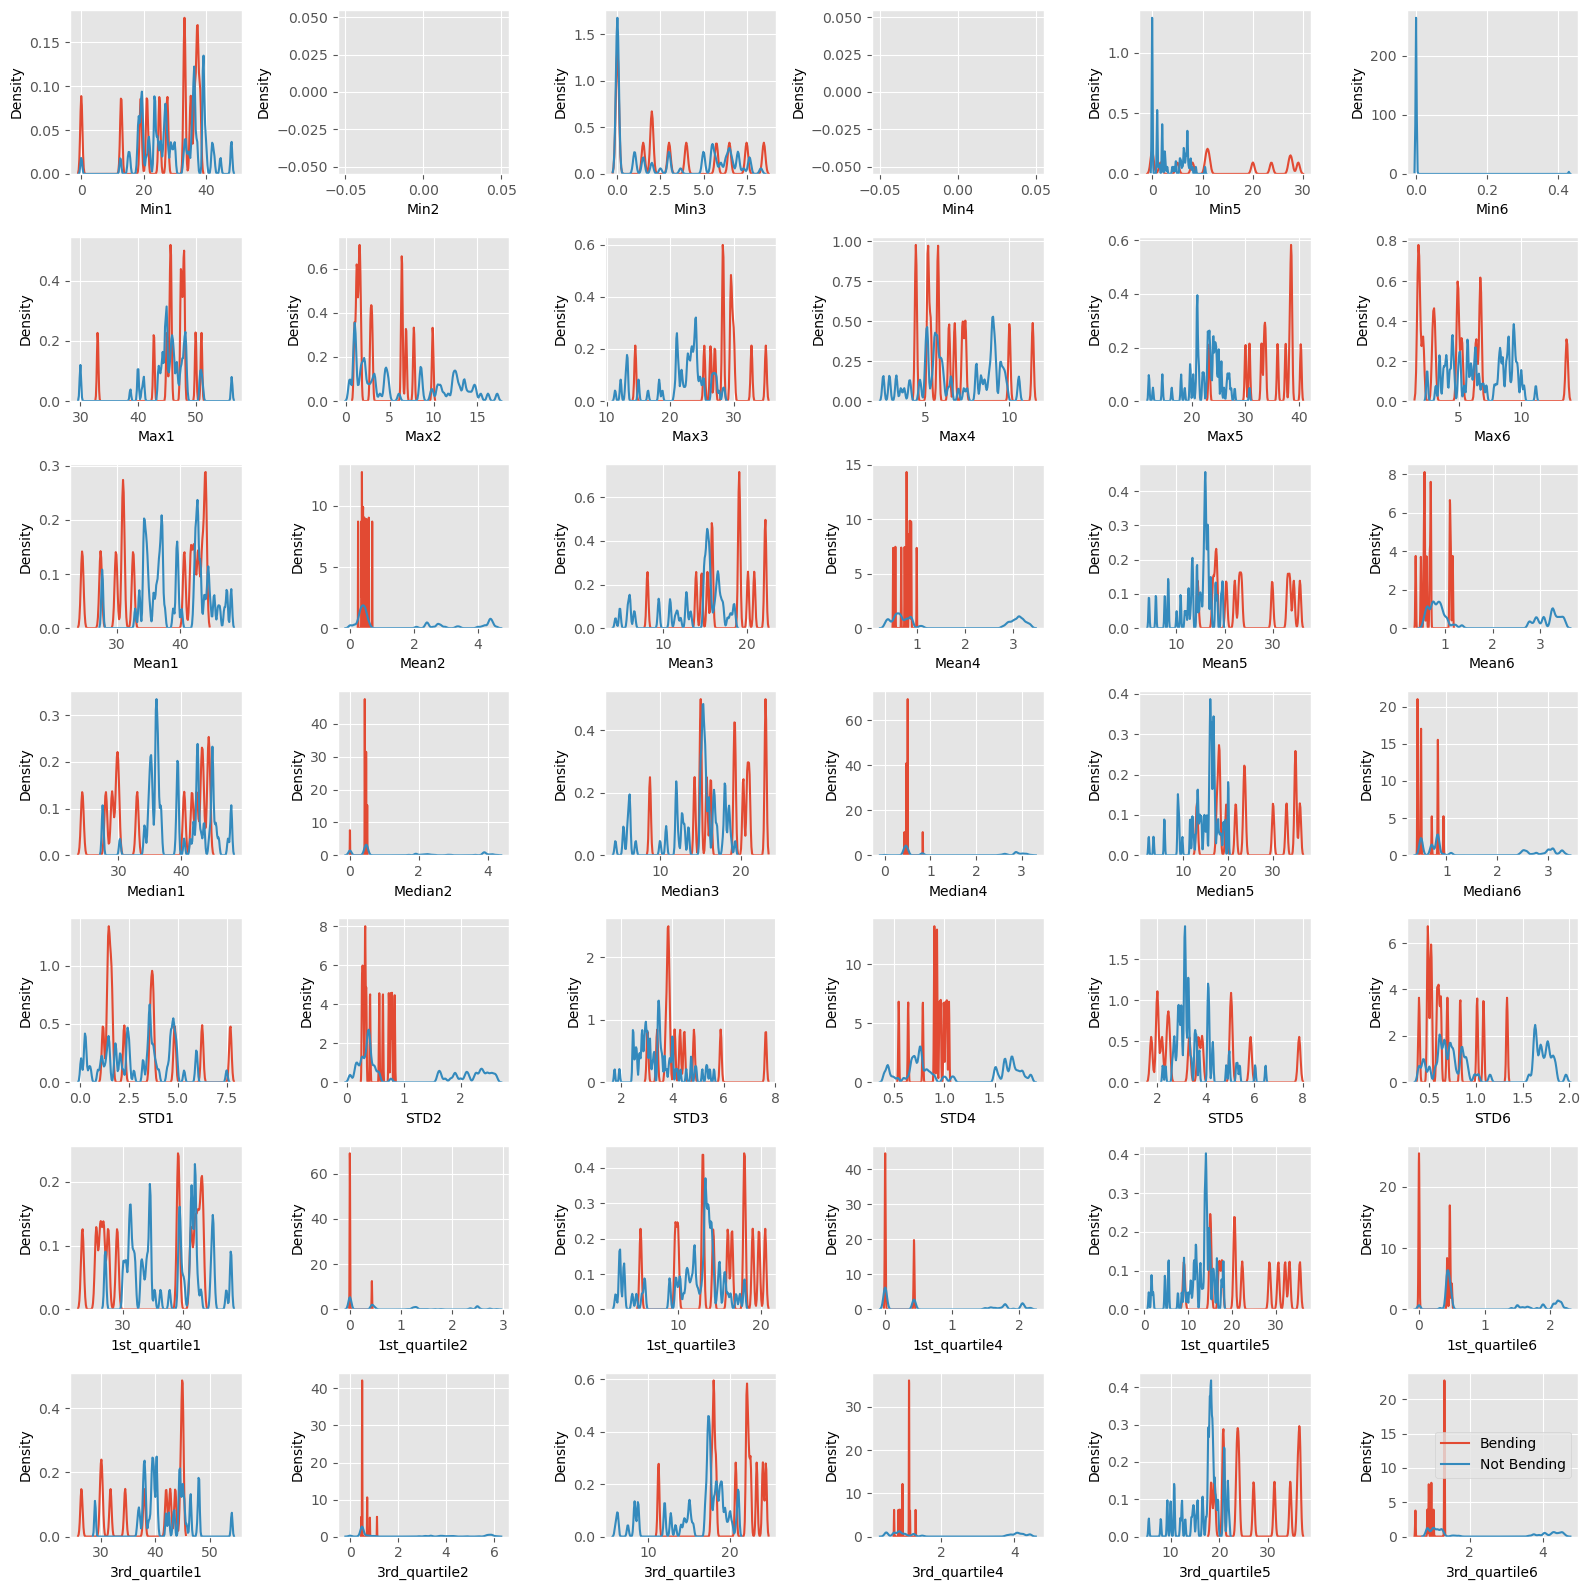

In [21]:
#7 Time-Domain Features and 6 time series
fig, axes = plt.subplots(7, 6, figsize=(16, 16))
for i in range(1, 7):
    for j, f in enumerate(ORDERED_STATS):
        sns.distplot(entire_data_bending.loc[entire_data_bending['Activity'] == 1, f + str(i)], 
                     kde = True, 
                     hist = False,
                     ax = axes[j, i-1],
                     label='Bending',
                     kde_kws={'bw':0.03}
                     )
        sns.distplot(entire_data_bending.loc[entire_data_bending['Activity'] == 0, f + str(i)], 
                     kde = True, 
                     hist = False,
                     ax = axes[j, i-1],
                     label='Not Bending',
                     kde_kws={'bw':0.03}
                    )
plt.tight_layout()
plt.legend()
plt.show()

Here we are using a binary case (i.e. bending/non-bending classification) here for a easier illustration of the judgement of time-domain features:

- Smaller overlap between two distributions of bending and non-bending curves is desired. This will allow a more clear and obvious decision boundary.
- High density distribution and a wider distribution signifies one class showing a representitive value.

Therefore, based on the principle to **relatively clear separated distributions**, we can conclude the top 3 as -->
- Max
- Mean
- 3rd Quartile

### 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

> **Answer** : The extra polynomial terms allow for a closer fit (more degrees of freedom) of the training data, so I would expect the training RSS for cubic regression to be lower than for simple linear regression.

(b) Answer (a) using test rather than training RSS.

> **Answer** : The RSS of the cubic model will be larger because of overfitting. A simple linear regression would generalize better to unseen data, therefore it is expected to have lower test RSS. The cubic model is likely to overfit the training data, so it is expect to have a higher test RSS.

(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

> **Answer** : The fundamental principle does not change. Polynomial regression has lower train RSS than the linear fit because of higher flexibility. No matter what the underlying true relationship is, the more flexible the model will be, lesser is the train RSS.

(d) Answer (c) using test rather than training RSS.

> **Answer** : The test RSS depends on how far from linear the true relationship of $f(x)$ is. If $f(x)$ is more linear than cubic, then cubic regression can overfit, so cubic RSS will be higher and linear RSS will be lower. If $f(x)$ is more cubic than linear, then linear regression can underfit, so linear RSS will be higher and cubic RSS will be lower. There is not enough information to tell which test RSS would be lower for either regression given the problem statement is defined as not knowing "how far it is from linear". 

# HOMEWORK 4 STARTS FROM HERE -->

# Time Series Classification Part 2: Binary and Multiclass Classification

## 2.(a). Binary Classification Using Logistic Regression

### 2(a-i). Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

In [22]:
# Function to get Pair-Plot for time series number (1,2,6) and top 3 selected features in Q1(c-iv).
def pairPlot(entire_data_bending, time_series_columns, top_3_features_selected):
    selected_features = [f + str(i) for i in time_series_columns for f in top_3_features_selected]
    selected_data = entire_data_bending[selected_features + ['Activity']]
    #print(selected_data)
    sns.pairplot(selected_data, hue='Activity')
    plt.show()

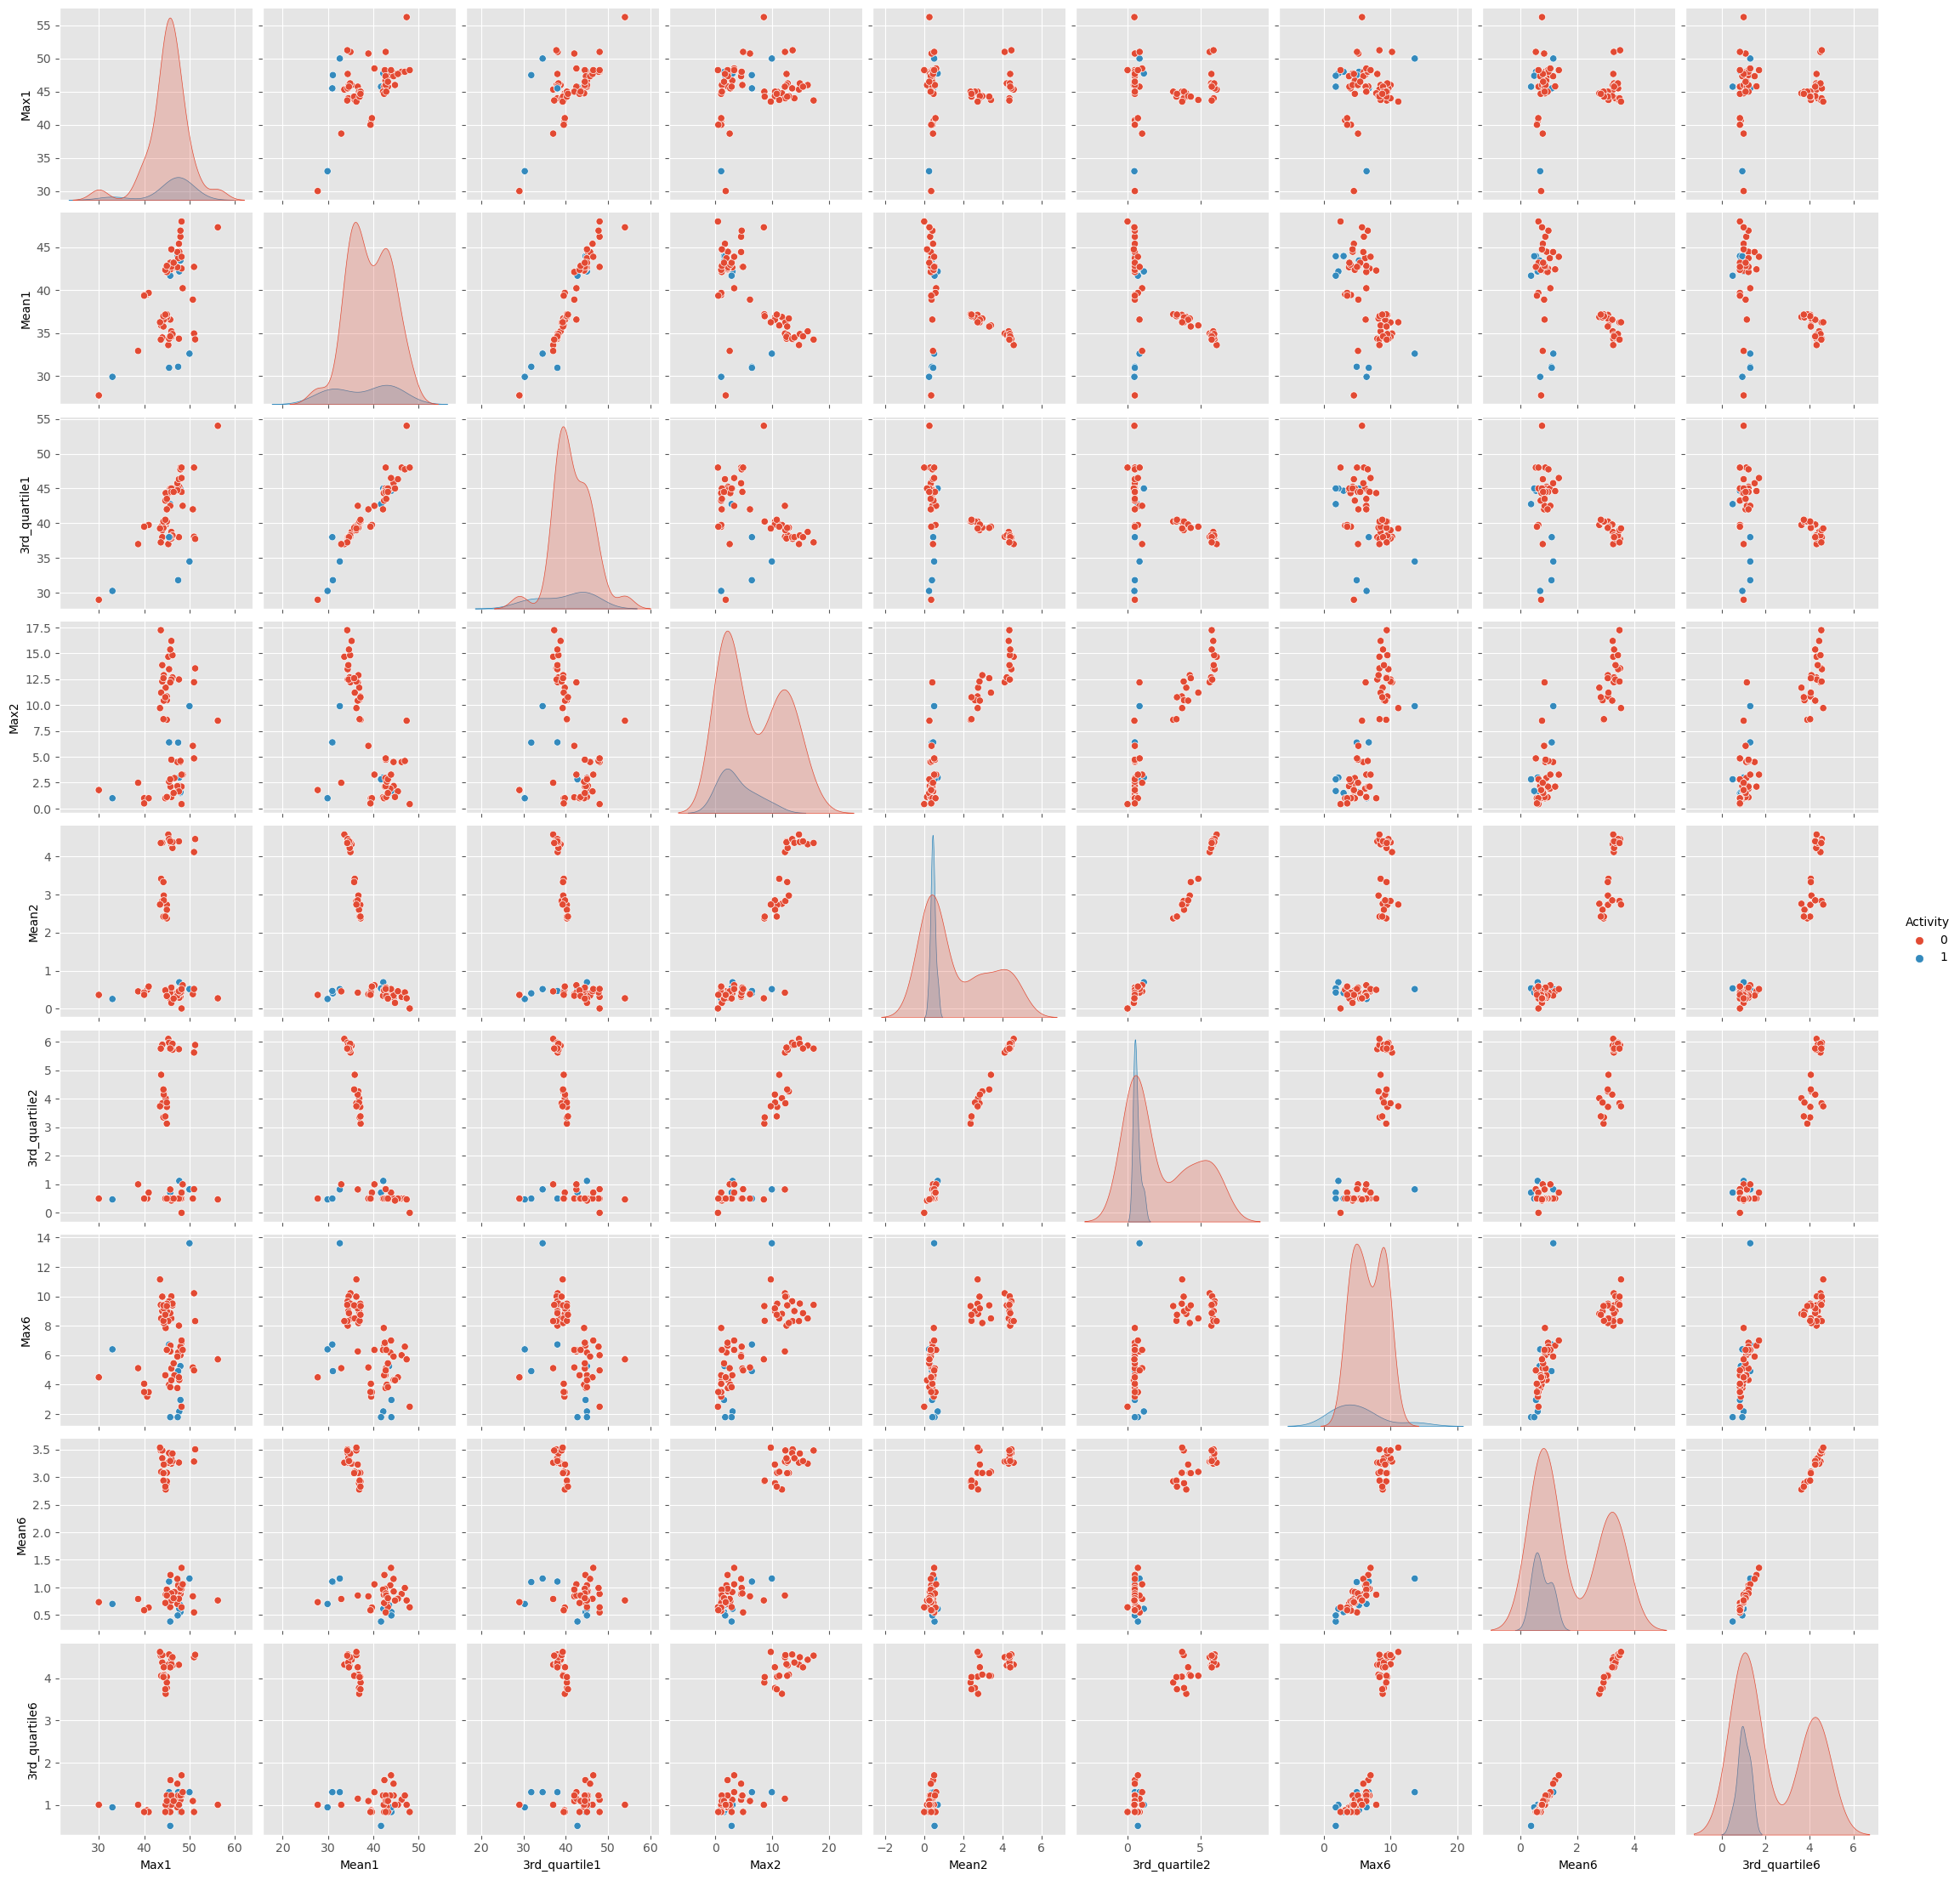

In [23]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 6 time series
train_data_bending = pd.DataFrame(train_data)
train_data_bending.loc[train_data_bending['Activity'].isin(['bending1', 'bending2']), 'Activity'] = 1
train_data_bending.loc[train_data_bending['Activity'] != 1, 'Activity'] = 0
train_data_bending
pairPlot(train_data_bending, [1, 2, 6], ['Max', 'Mean', '3rd_quartile'])

### 2(a-ii). Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [24]:
# Reorder the columns since we will be having 12 columns now
time_Series_features = [feature + str(i) for i in range(1, 13) for feature in ORDERED_STATS]

# load dataset For TRAINING DATA: breaking each time series into 2 folds
time_series_12_train_data = load_data_from_csv(train, time_Series_features, OG_COLUMN_NAMES, segs=2)
train_data_2fold = pd.DataFrame(time_series_12_train_data)
train_data_2fold.loc[train_data_2fold['Activity'].isin(['bending1', 'bending2']), 'Activity'] = 1
train_data_2fold.loc[train_data_2fold['Activity'] != 1, 'Activity'] = 0
train_data_2fold

Min1   Max1      Mean1  Median1      STD1  1st_quartile1  3rd_quartile1  \
0   36.67  45.00  43.486208    43.71  1.281976        42.3300          44.50   
1   39.00  48.00  44.117042    45.00  1.359836        43.5000          45.00   
2   33.75  47.75  43.278875    45.00  3.473355        42.0000          45.25   
3   33.00  45.75  41.621208    42.33  3.118644        39.6525          44.25   
4   36.50  46.50  44.057167    44.50  1.556971        43.2500          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  20.00  44.25  35.692167    35.50  4.643595        33.0000          39.25   
65  24.25  45.00  36.954208    36.00  3.772836        34.2500          40.25   
66  27.00  42.67  36.337908    36.75  3.655379        33.6700          39.00   
67  26.25  43.40  36.865417    36.25  3.462793        34.3100          40.00   
68  27.75  44.00  37.132636    36.67  3.808255        34.0000          40.33   

    Min2   Max2     Mean2  ...  1st_quartile11  3rd_quartile11  Min12  Max12  \
0    0.0   1.30  0.378667  ...          21.000         23.5000    0.0   2.96   
1    0.0   1.30  0.250042  ...          22.500         23.7500    0.0   4.06   
2    0.0   3.00  0.673292  ...          28.750         33.7500    0.0   2.18   
3    0.0   2.83  0.623083  ...          28.310         30.5625    0.0   1.50   
4    0.0   1.50  0.381042  ...          33.000         36.2500    0.0   1.50   
..   ...    ...       ...  ...             ...             ...    ...    ...   
64   0.0  11.39  3.324208  ...          14.000         18.2500    0.0   8.81   
65   0.0   8.18  2.392667  ...          18.000         21.6700    0.0   9.34   
66   0.0   9.71  2.698494  ...          16.125         21.0000    0.0  11.15   
67   0.0   7.46  2.387250  ...          14.330         18.0000    0.0   8.34   
68   0.0  10.76  2.388870  ...          15.000         18.7500    0.0   7.93   

      Mean12  Median12     STD12  1st_quartile12  3rd_quartile12  Activity  
0   0.585750      0.50  0.487918          0.4225          0.8300         1  
1   0.543875      0.50  0.473445          0.4300          0.7100         1  
2   0.586083      0.47  0.491873          0.0000          0.8700         1  
3   0.347500      0.43  0.363144          0.0000          0.5000         1  
4   0.388333      0.00  0.478528          0.0000          0.7100         1  
..       ...       ...       ...             ...             ...       ...  
64  2.966917      2.59  1.712062          1.8525          3.7400         0  
65  2.838083      2.45  1.890755          1.3825          3.8325         0  
66  3.530669      3.08  1.998170          2.1700          4.5150         0  
67  2.904458      2.57  1.609793          1.6900          3.7700         0  
68  2.727866      2.55  1.588045          1.5000          3.7000         0  

[69 rows x 85 columns]

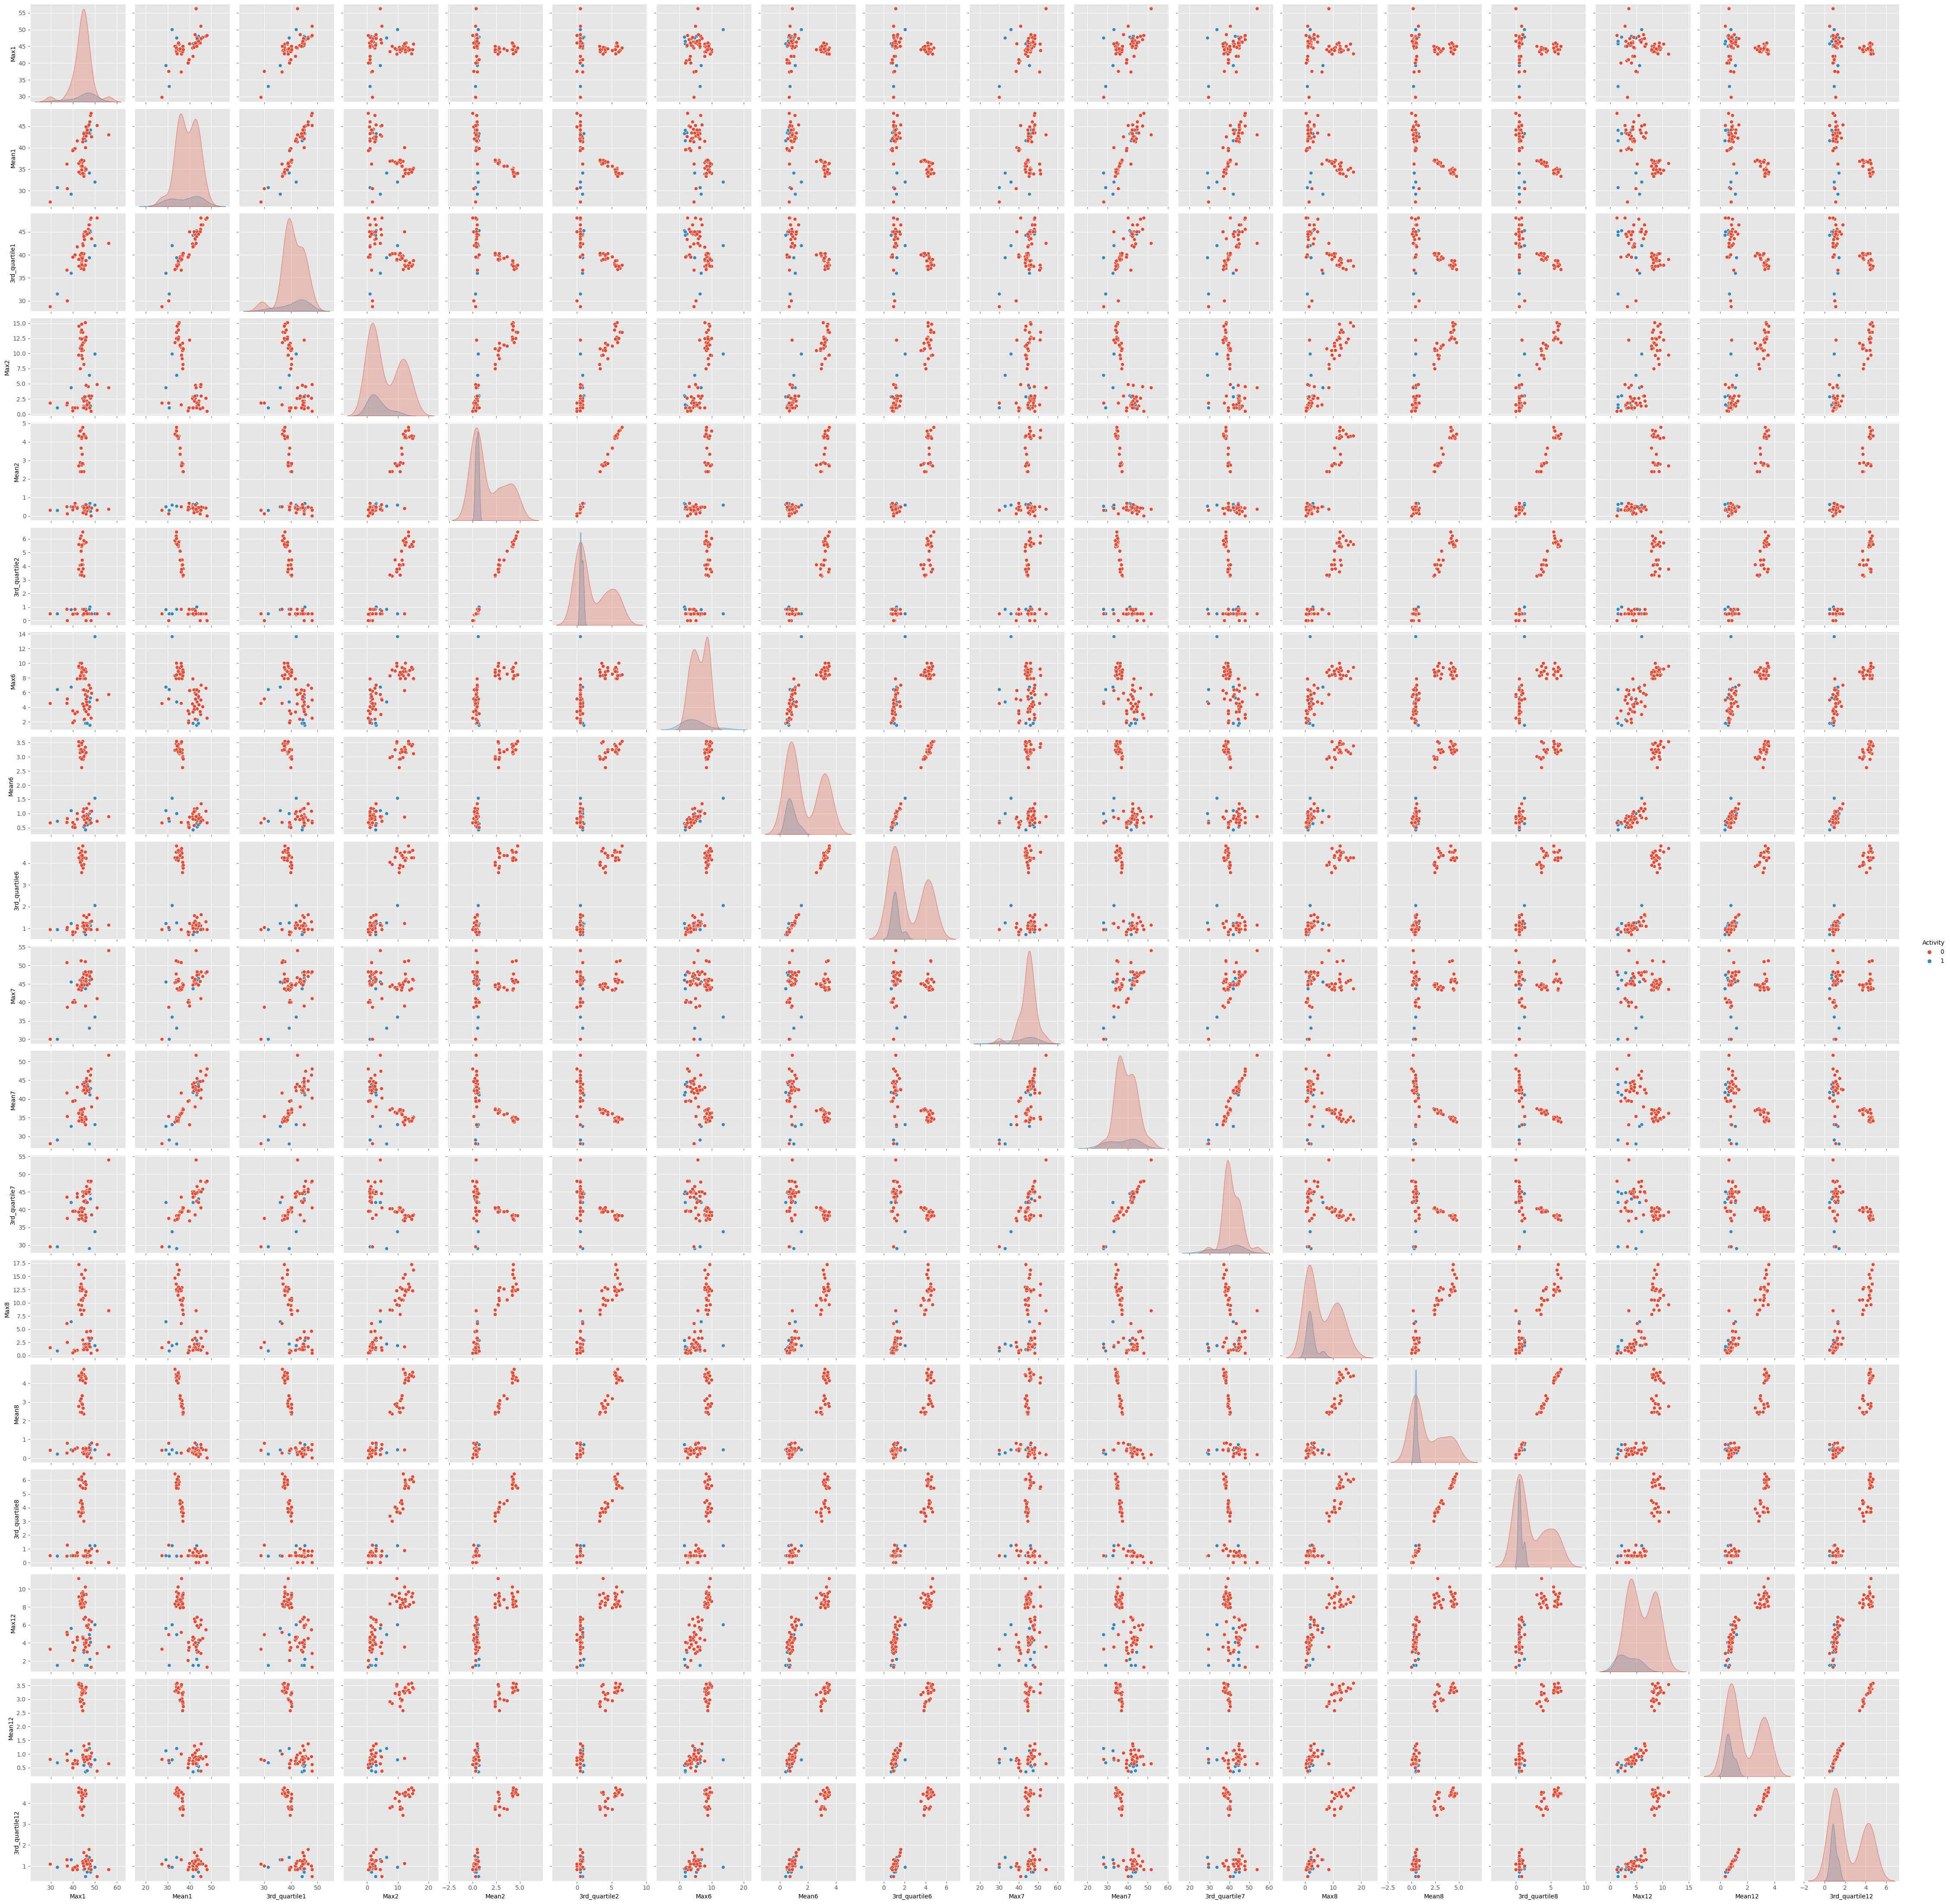

In [25]:
pairPlot(train_data_2fold, [1, 2, 6, 7, 8, 12], ['Max', 'Mean', '3rd_quartile'])

#### OBSERVATION
> By comparing two plots generated above, we can conclude that the distributions look almost similar at the first glance don't have any significant difference.

### 2(a-iii). Break each time series in your training set into l in set {1, 2, ..., 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed. In the following, you can see an example of applying Python's Recursive Feature Elimination, which is a backward selection algorithm, to logistic regression.**

In [26]:
def perform_logistic_regression(train_files, test_files, l_val, fold_count, oversample=False, penalty='none'):
    print(f'===> Executing Logistic Regression with L-value ::: {l_val}')
    
    # Step 1 : Break time series in the training set into L time series of approx equal length.
    features = get_features(ORDERED_STATS, 6 * l_val + 1)
    train_set = load_data_from_csv(train_files, features, OG_COLUMN_NAMES, segs=l_val)
    
    training_data = pd.DataFrame(train_set)
    training_data.loc[training_data['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
    training_data.loc[training_data['Activity'] != "1", 'Activity'] = "0"
    
    # Oversample flag to take care of Q2(a-vii)
    if oversample:
        training_data = perform_oversampling(training_data)
    
    # Step 2 : Divide new training dataset into the corresponding predictors and response for classification purpose
    trainX = training_data.iloc[:, :-1]
    trainY = training_data.iloc[:, -1]

    # Theliblinear solver is preferable for reducing no.of features & obtaining sparse model - L1 regularization
    # The lbfgs (good all-purpose solver) for small/medium-sized datasets : supports Multinomial Logistic Regression
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    
    # Step 3 : Handle the issue of class imbalance to avoid some folds having no rare class instances
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    
    # Step 4 : Logistion Regression to solve the Binary Classification Problem
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    
    # Step 5 : Select the best subset of features for the supplied estimator by removing 0 to N features 
    # (where N is the number of features) using recursive feature elimination, 
    # then selecting the best subset based on the cross-validation score of the model.
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    
    return model, selector

def get_features(stats, ending_index):
    features = []
    for i in range(1, ending_index):
        for stat in stats:
            features.append(f'{stat}{i}')
    return features

In [27]:
L = 20
cross_validation_factor = 5

evaluate_different_combinations = {
    'Pair(L, No.of Features)': [],
    'Score': []
}

for l_value in range(1, L + 1):
    model, selector = perform_logistic_regression(train, test, l_value, cross_validation_factor, oversample=False)
    number_of_features = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    evaluate_different_combinations['Pair(L, No.of Features)'].append((l_value, number_of_features))
    evaluate_different_combinations['Score'].append(round(score, 4))
    
summary = pd.DataFrame(evaluate_different_combinations)
summary

===> Executing Logistic Regression with L-value ::: 1
===> Executing Logistic Regression with L-value ::: 2
===> Executing Logistic Regression with L-value ::: 3
===> Executing Logistic Regression with L-value ::: 4
===> Executing Logistic Regression with L-value ::: 5
===> Executing Logistic Regression with L-value ::: 6
===> Executing Logistic Regression with L-value ::: 7
===> Executing Logistic Regression with L-value ::: 8
===> Executing Logistic Regression with L-value ::: 9
===> Executing Logistic Regression with L-value ::: 10
===> Executing Logistic Regression with L-value ::: 11
===> Executing Logistic Regression with L-value ::: 12
===> Executing Logistic Regression with L-value ::: 13
===> Executing Logistic Regression with L-value ::: 14
===> Executing Logistic Regression with L-value ::: 15
===> Executing Logistic Regression with L-value ::: 16
===> Executing Logistic Regression with L-value ::: 17
===> Executing Logistic Regression with L-value ::: 18
===> Executing Logi

Pair(L, No.of Features)   Score
0                   (1, 6)  1.0000
1                   (2, 5)  0.9429
2                   (3, 7)  0.9857
3                   (4, 9)  0.9714
4                   (5, 3)  0.9857
5                  (6, 36)  0.9857
6                  (7, 16)  0.9714
7                  (8, 31)  0.9714
8                  (9, 43)  0.9857
9                 (10, 47)  0.9714
10                 (11, 9)  0.9857
11                (12, 85)  0.9857
12                (13, 12)  0.9857
13                (14, 15)  0.9714
14                (15, 37)  0.9857
15                (16, 12)  0.9857
16                (17, 11)  0.9857
17                 (18, 9)  0.9857
18                (19, 10)  0.9857
19                (20, 11)  0.9857

**Observation**:

> - By performing feature selection along with cross-validation, we can ensure that our model's performance estimates are less biased and more reliable, leading to better generalization performance on unseen data. The purpose of cross-validation is to assess, tune, and select models, while also providing insights into their generalization capabilities and potential pitfalls such as overfitting. . We do not want to deprive our algorithm with the knowledge of the various predictors available at the disposal of our dataset. Therefore, the right method would be to do the Recursive Feature Elimination (RFE) along with Cross Validation. The other way round, i.e. RFE before performing Cross Validation is incorrect.

### 2(a-iv.) Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [28]:
def get_selected_features(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]: #The mask of selected features. [True, False, True, True, ... ]
            selected_features.append(feature)
    return selected_features

# Extracting the selected features
l_value = 1
features = get_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = perform_logistic_regression(train, test, l_value, fold_count=5)
selected_features = get_selected_features(features, selector) # These optimal features helps decide whether the new data point is bending or non-bending
selected_features

===> Executing Logistic Regression with L-value ::: 1


['Mean1', '3rd_quartile1', 'Max2', 'Min5', 'Max5', '1st_quartile5']

In [29]:
training_data = load_data_from_csv(train, selected_features, OG_COLUMN_NAMES, segs=1)

training_data = pd.DataFrame(training_data)
training_data.loc[training_data['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
training_data.loc[training_data['Activity'] != "1", 'Activity'] = "0"

trainX, trainY = training_data.iloc[:, :-1], training_data.iloc[:, -1]
temp = trainX.loc[:, selected_features]

# sm.add_constant() used to add a constant term (intercept) to a dataset for use in linear regression models. 
# The constant term represents the intercept/baseline value of the dependent variable when all predictors are zero.
const_val = sm.add_constant(temp.to_numpy(dtype=float))

# Performing logistic regression analysis. "BFGS" is a popular optimization algorithm in logistic regression.
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Thu, 05 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        12:06:53   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

In [30]:
# Plot the ROC curve and AUC
def ROC_Curve(actualY, predictedY_prob, classifier):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC Curves")
    for i, clazz in enumerate(classifier.classes_):
        y_predicted = predictedY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label=clazz)
        roc_auc = auc(fpr, tpr)
#         print(f"Class: {clazz}; ROC Curve Area: {round(roc_auc, 4)}")
        axes.plot(fpr, tpr, label=f"Class: {clazz}; ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()
    
# Perform classification and plot the ROC curves
def classify_and_calculate_ROC(dataX, dataY, selected_features, isTest=False):
    if not isTest:
        classifier.fit(dataX.loc[:, selected_features], dataY.to_numpy(dtype="int"))
    predictY = classifier.predict(dataX.loc[:, selected_features])
    
    # Obtain the probability estimates for each class label for a given input sample. 
    # To see how confident the classifier is about its predictions.
    predictY_prob = classifier.predict_proba(dataX.loc[:, selected_features])
    y_true = dataY.to_numpy(dtype=float)
    y_pred = predictY.round()
    confusionMatrix = confusion_matrix(y_true, y_pred)
    print(confusionMatrix)

    ROC_Curve(y_true, predictY_prob, classifier)

[[60  0]
 [ 0  9]]


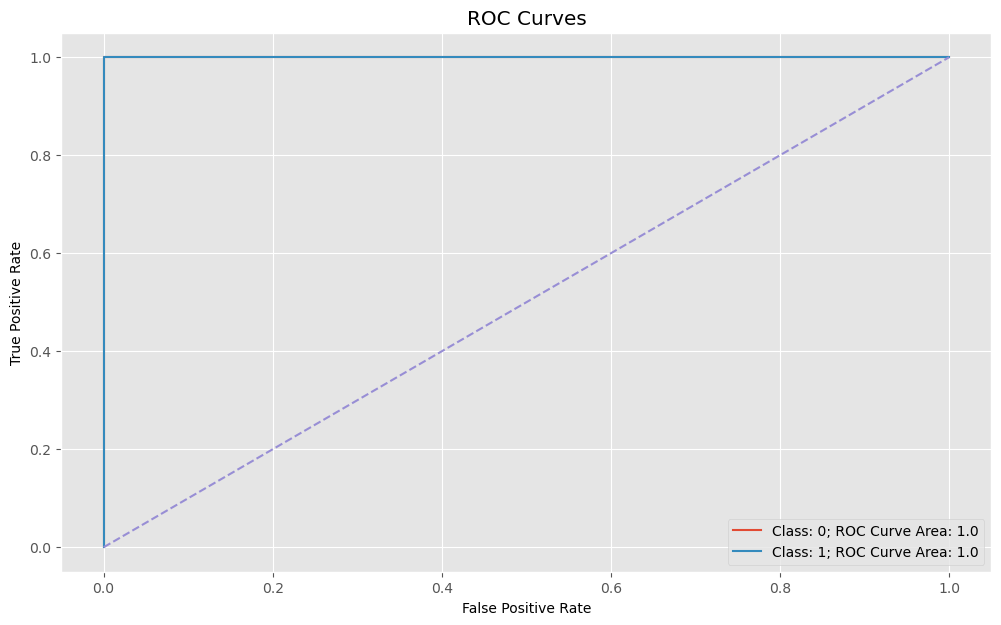

In [31]:
classify_and_calculate_ROC(trainX, trainY, selected_features)

### 2(a-v.) Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [32]:
test_data = load_data_from_csv(test, selected_features, OG_COLUMN_NAMES, segs=1)

test_data = pd.DataFrame(test_data)
test_data.loc[test_data['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
test_data.loc[test_data['Activity'] != "1", 'Activity'] = "0"

testX, testY = test_data.iloc[:, :-1], test_data.iloc[:, -1]

testX

Mean1  3rd_quartile1   Max2   Min5   Max5  1st_quartile5
0   40.624792        42.0000   1.30  27.25  38.25        33.0000
1   42.812812        43.6700   1.22  27.67  38.50        32.0000
2   34.227771        37.7500  14.50   6.75  26.00        14.7500
3   33.509729        36.7500  13.05   7.25  25.00        14.6275
4   34.660583        38.2500  13.44   7.00  24.50        14.2500
5   24.562958        26.5000   6.87  10.67  30.00        20.5000
6   27.464604        30.0000   7.76   0.00  33.00        15.0000
7   44.334729        46.5000   3.90   0.00  23.00         9.3300
8   43.174938        44.5000   2.12   2.00  21.25        12.7500
9   42.760562        45.3725   3.34   1.33  21.33        13.0000
10  42.363563        43.5000   4.44   1.00  28.00        10.1875
11  45.917667        46.5000   4.87   2.00  24.00        16.5000
12  45.239667        45.3300   1.00   4.75  26.75        17.6275
13  27.716375        29.0000   1.79   0.00  21.00         5.5000
14  44.182937        48.0000   3.11   0.00  12.75         2.0000
15  48.004167        48.0000   0.43   0.00  12.00         4.6700
16  37.177042        40.2500   8.58   7.00  25.50        17.9500
17  37.561187        40.2500   9.91  10.50  24.33        18.0000
18  37.058708        40.0625  14.17   7.50  24.25        16.0000

[[15  0]
 [ 0  4]]


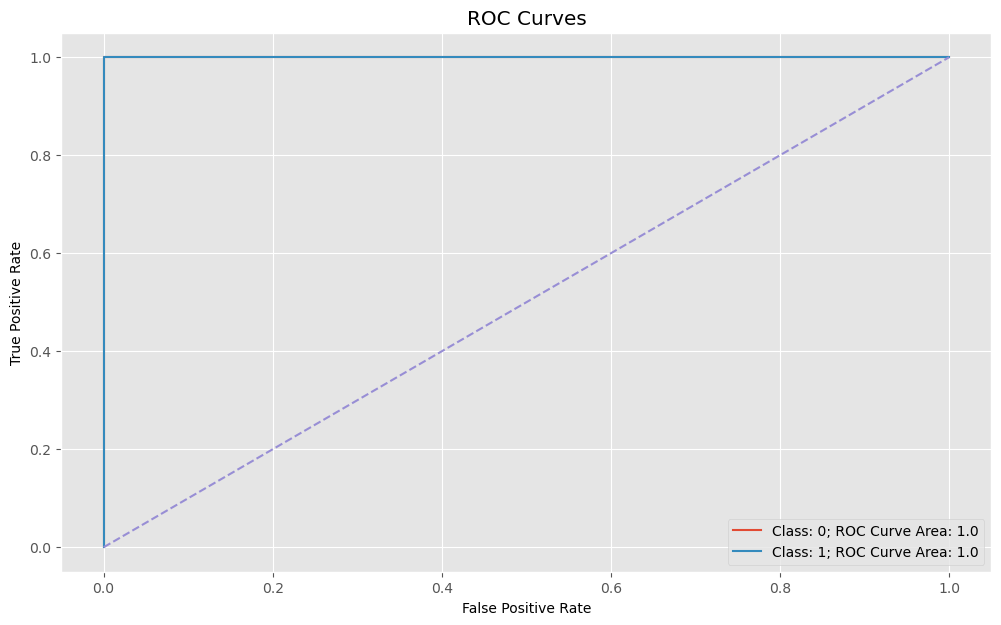

In [33]:
classify_and_calculate_ROC(testX, testY, selected_features, isTest=True)

**Observation:**

> The test set as well as cross validation is observed to be of the same accuracy.

### 2(a-vi.) Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

>***The message "Complete Separation" in the p-value analysis using statmodel indicates that there is complete separation in our data. Complete separation occurs when the logistic regression model can perfectly separate the two classes based on the predictor variables. This can lead to issues with parameter estimation and model interpretation. The message suggests that the Maximum Likelihood Estimator does not exist and the parameters are not identified in this case. Due to this finding, it is possible that the well-separation of the classes is causing the instability in calculation of the regression parameters.***

### 2(a-vii.) From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

***Observations:***

- As per the above classification, we have class 0 = non-bending and class 1 = bending. According to the confusion matrix that is computed for the training dataset, there are 69 instances in the non-bending class and 9 instances in the bending class. This  shows that there is considerable amount of class imbalance observed. To mitigate this issue, we will have to build a regression model on case-controlled sampling i.e. we will have to implement oversampling to cover up for the rare class.

In [34]:
def perform_oversampling(data_set):
    print('Executing the oversampling of dataset...')
    class_0 = data_set.loc[data_set['Activity'] == "0"].shape[0]
    class_1 = data_set.loc[data_set['Activity'] == "1"].shape[0]
    minor_count = min(class_0, class_1)
    major_count = max(class_0, class_1)
    
    if class_0 > class_1:
        minor_class = "1"
        major_class = "0"
    else:
        minor_class = "0"
        major_class = "1"
        
    minor = data_set[data_set['Activity'] == minor_class]
    major = data_set[data_set['Activity'] == major_class]
    minor = resample(minor, replace=True, random_state=60, n_samples=max(class_0, class_1))
    data_set = pd.concat([major, minor])
    return data_set

# Implementing Logistic Regression with Oversampling
L = 20
cross_validation_factor = 5

evaluate_different_combinations = {
    'Pair(L, No.of Features)': [],
    'Score': []
}

for l_value in range(1, L + 1):
    model, selector = perform_logistic_regression(train, test, l_value, cross_validation_factor, oversample=True)
    number_of_features = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    evaluate_different_combinations['Pair(L, No.of Features)'].append((l_value, number_of_features))
    evaluate_different_combinations['Score'].append(round(score, 4))
    
summary = pd.DataFrame(evaluate_different_combinations)
summary

===> Executing Logistic Regression with L-value ::: 1
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 2
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 3
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 4
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 5
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 6
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 7
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 8
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 9
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value ::: 10
Executing the oversampling of dataset...
===> Executing Logistic Regression with L-value :

Pair(L, No.of Features)   Score
0                   (1, 4)  1.0000
1                   (2, 7)  0.9833
2                   (3, 3)  1.0000
3                   (4, 3)  0.9917
4                   (5, 3)  0.9917
5                   (6, 3)  0.9917
6                   (7, 2)  0.9917
7                   (8, 3)  0.9917
8                   (9, 9)  1.0000
9                  (10, 6)  1.0000
10                 (11, 2)  0.9917
11                 (12, 8)  1.0000
12                 (13, 4)  1.0000
13                 (14, 7)  1.0000
14                 (15, 9)  1.0000
15                 (16, 8)  1.0000
16                 (17, 4)  1.0000
17                 (18, 3)  1.0000
18                 (19, 6)  1.0000
19                 (20, 7)  1.0000

===> Executing Logistic Regression with L-value ::: 1
Executing the oversampling of dataset...
The selected features for L value = 1 are : ['3rd_quartile1', 'Min5', 'Max5', 'Mean5']
Executing the oversampling of dataset...
[[60  0]
 [ 0 60]]


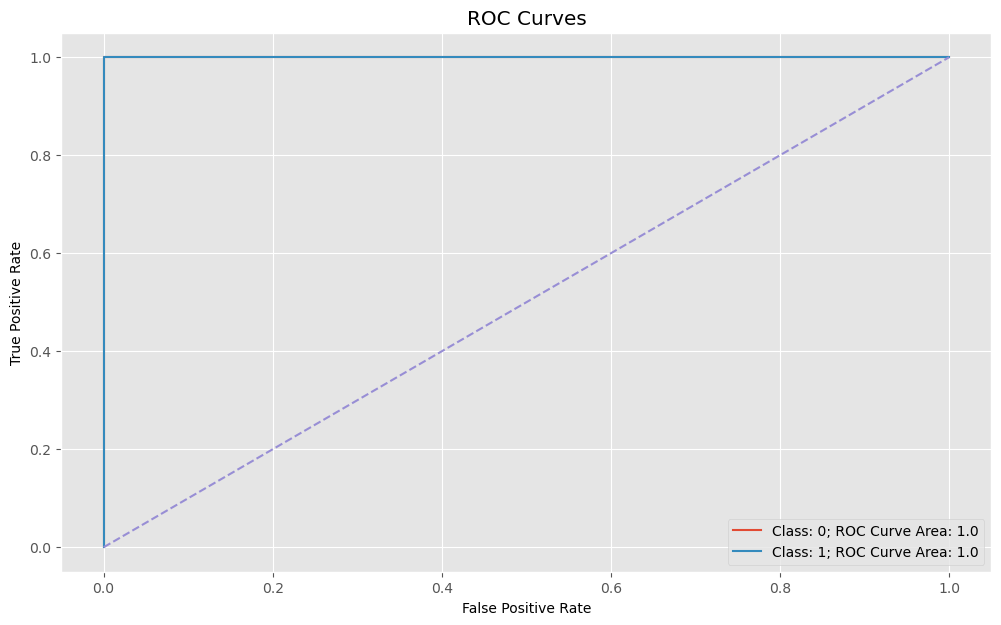

In [35]:
# Extracting the selected features
l_value = 1
features = get_features(ORDERED_STATS, 6 * l_value + 1)
classifier, selector = perform_logistic_regression(train, test, l_value, fold_count=5, oversample=True)
selected_features = get_selected_features(features, selector) 
# These optimal features helps decide whether the new data point is bending or non-bending
print(f"The selected features for L value = {l_value} are : {selected_features}")

#Logistic Regression Model on the Oversampled Training Data
training_data = load_data_from_csv(train, selected_features, OG_COLUMN_NAMES, segs=1)

#Converting text labels to binary labels
training_data = pd.DataFrame(training_data)
training_data.loc[training_data['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
training_data.loc[training_data['Activity'] != "1", 'Activity'] = "0"

training_data = perform_oversampling(training_data)

trainX, trainY = training_data.iloc[:, :-1], training_data.iloc[:, -1]
classify_and_calculate_ROC(trainX, trainY, selected_features)

[[15  0]
 [ 0  4]]


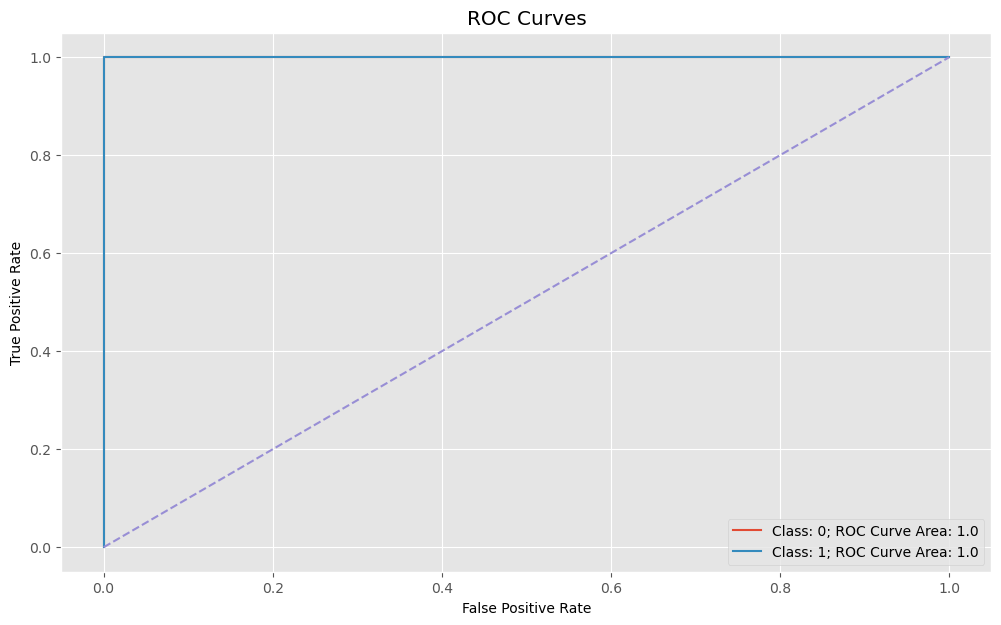

In [36]:
# Predict the Test Data from the Logistic Regression Model developed using Oversampled Training data
test_data = load_data_from_csv(test, selected_features, OG_COLUMN_NAMES, segs=1)

#Converting text labels to binary labels
test_data = pd.DataFrame(test_data)
test_data.loc[test_data['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
test_data.loc[test_data['Activity'] != "1", 'Activity'] = "0"

testX, testY = test_data.iloc[:, :-1], test_data.iloc[:, -1]
classify_and_calculate_ROC(testX, testY, selected_features)

## 2b) Binary Classification Using L1-penalized logistic regression

### 2b-i) Repeat 2(a)iii using L1-penalized logistic regression, i.e. instead of using pvalues for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and lambda, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for lambda automatically.

In [37]:
max_test_accuracy = 0
optimal_L = 1

# Perform Regression on the basis of the selected classifier
def Regression_With_Classifier(classifier, classifier_name, l_value, kwargs, penalty='none', 
                              is_binary_classification=True, draw_roc=False):
    
    print(f'Running {classifier_name} for l-value {l_value}')
    
    features = get_features(ORDERED_STATS, 6 * l_value + 1)
    training = load_data_from_csv(train, features, OG_COLUMN_NAMES, segs=l_value)
    testing = load_data_from_csv(test, features, OG_COLUMN_NAMES, segs=l_value)
    
    if is_binary_classification:
        training = pd.DataFrame(training)
        training.loc[training['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
        training.loc[training['Activity'] != "1", 'Activity'] = "0"
        
        testing = pd.DataFrame(testing)
        testing.loc[testing['Activity'].isin(['bending1', 'bending2']), 'Activity'] = "1"
        testing.loc[testing['Activity'] != "1", 'Activity'] = "0"
        
    trainX, trainY = training.iloc[:, :-1], training.iloc[:, -1]
    testX, testY = testing.iloc[:, :-1], testing.iloc[:, -1]
    
    if is_binary_classification:
        # trainY, testY are of type object, so sklearn cannot recognize its type. Hence converting to 'int'
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    classifier_instance = classifier(**kwargs)
    classifier_instance.fit(trainX, trainY)
    
    if not draw_roc:    
        train_score = round(classifier_instance.score(trainX, trainY), 4)
        test_score = round(classifier_instance.score(testX, testY), 4)
        print(f'Value of L: {l_value} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_value} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_value
        
        if l_value == 20:
            print('\n')
            print(f'The maximum accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
            print(f'Further calculations will be done with L-value: {optimal_L}')
        
    else:
        train_predictY_probability = classifier_instance.predict_proba(trainX)
        test_predictY_probability = classifier_instance.predict_proba(testX)

        predictY = classifier_instance.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        print("ROC Curve for Train Data")
        ROC_Curve(trainY, train_predictY_probability, classifier_instance)
        
        print("ROC Curve for Test Data")
        ROC_Curve(testY, test_predictY_probability, classifier_instance)

In [38]:
# making use of the varargs concept
kwargs = { 'penalty' : 'l1', 'max_iter' : 100, 'scoring' : 'accuracy', 'cv' : 5, 
           'random_state' : 69,'solver' : 'liblinear' }

fold_count = 5

# performing regression for each value of L for 20 iterations
for l_val in range(1, 21):
    Regression_With_Classifier(LogisticRegressionCV, "Logistic Regression", l_val, kwargs, 
                               penalty='none', is_binary_classification=True, draw_roc=False)

Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 0.9565 | test_score: 0.9474
Value of L: 2 | train_error: 0.0435 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.9474
Value of L: 4 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.9474
Value of L: 5 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.9474
Value of L: 6 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 1.0
Value o

Running Logistic Regression for l-value 1
Confusion matrix for test data:
[[15  0]
 [ 0  4]]
ROC Curve for Train Data


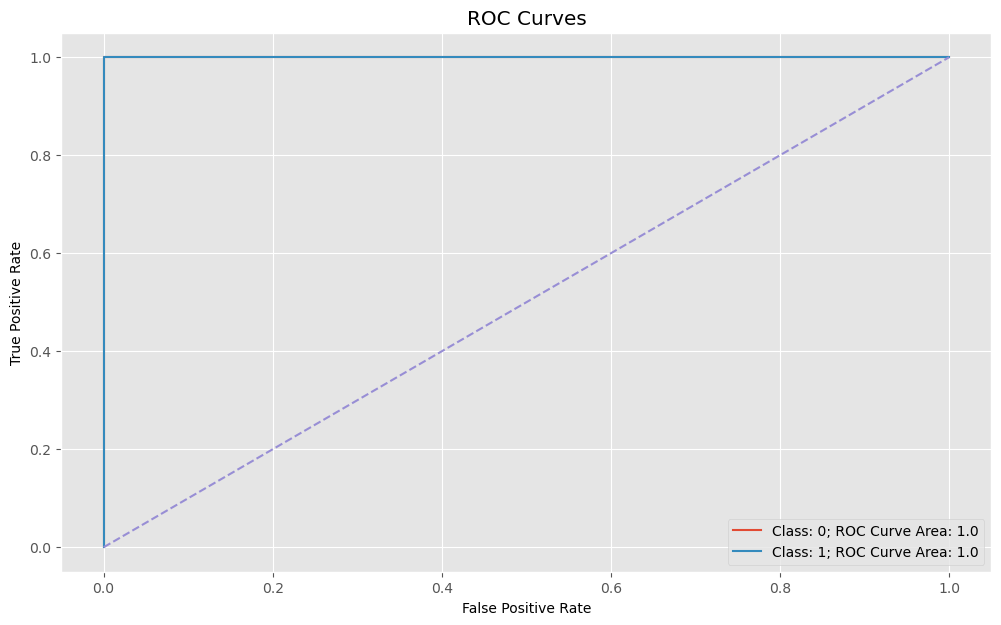

ROC Curve for Test Data


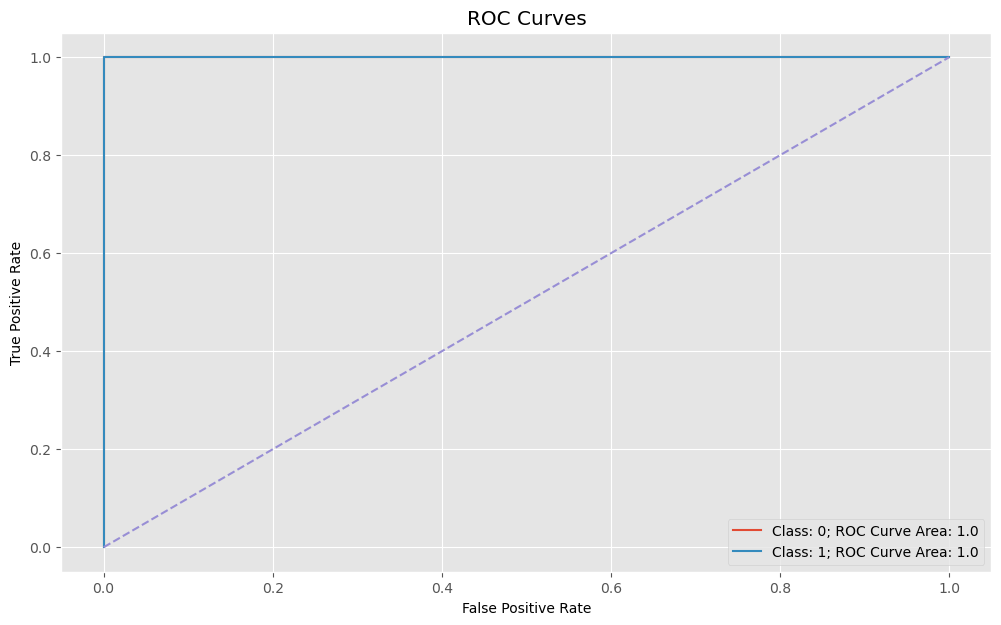

In [39]:
kwargs = { 'penalty' : 'l1', 'max_iter' : 100, 'solver' : 'liblinear' }

best_l = 1

# performing regression with the given classifier for the best value of L calculated from the above cell
Regression_With_Classifier(LogisticRegression, "Logistic Regression",
                           best_l, kwargs, penalty='none', is_binary_classification=True, draw_roc=True)

### 2(b-ii) Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?**

**Observations:**
> - The L1-penalized logistic regression has better performance in terms of accuracy when tested on the test data (approximately ~ 1.0) and hence, the L1-penalized performs better. THe L1-regularization is easier to implement as feature selection does not need to be manual, as well as it encourages sparsity in the model, which means it automatically selects a subset of the most important features while setting others' coefficients to zero. This can simplify the model and potentially reduce overfitting. It can also handle multicollinearity by selecting one feature from a group of highly correlated features. Variable selection with p-values does not give these advantages and requires us to select features manually after an intensive computation for p-values.

## 2c) Multi-class Classification (The Realistic Case)

### 2(c-i) Find the best l in the same way as you found it in 2(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [40]:
kwargs = { 'penalty' : 'l1', 'max_iter' : 100, 'multi_class': 'multinomial', 
           'cv': 5, 'random_state' : 69, 'solver' : 'saga' }

global optimal_L
optimal_L = 1

global max_test_accuracy
max_test_accuracy = 0


for l_value in range(1, 21):
    Regression_With_Classifier(LogisticRegressionCV, "Logistic Regression",
                               l_value, kwargs, penalty='none', is_binary_classification=False, draw_roc=False)


Running Logistic Regression for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.9474
Value of L: 2 | train_error: 0.0 | test_error: 0.0526

Running Logistic Regression for l-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.8421
Value of L: 3 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.8947
Value of L: 4 | train_error: 0.0 | test_error: 0.1053

Running Logistic Regression for l-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.8421
Value of L: 5 | train_error: 0.0 | test_error: 0.1579

Running Logistic Regression for l-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.7895
Value of L: 6 | train_error: 0.0 | test_error: 0.2105

Running Logistic Regression for l-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.736

Optimal L : 2
Running Logistic Regression for l-value 2
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


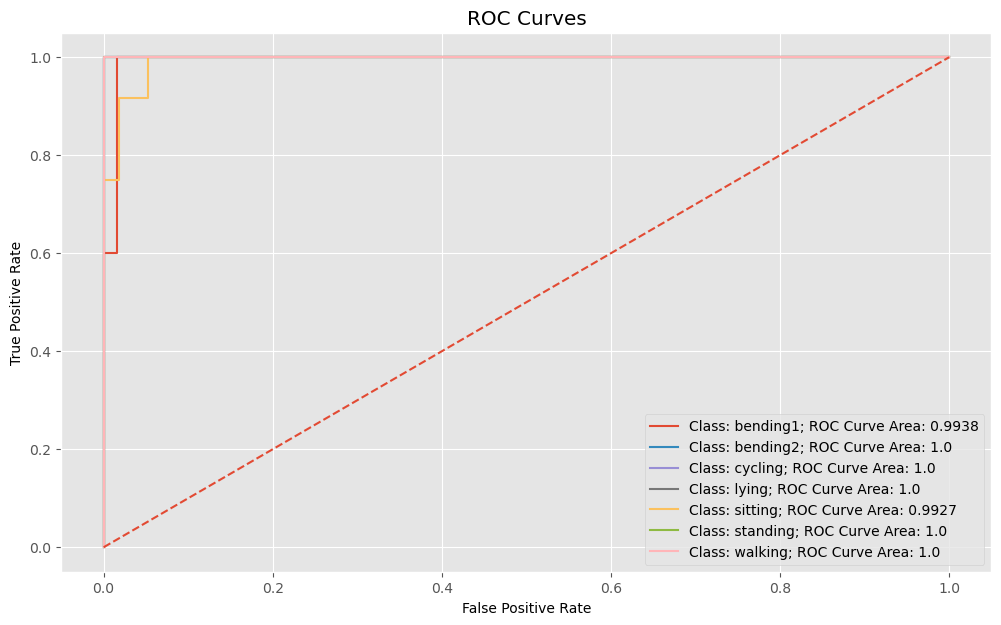

ROC Curve for Test Data


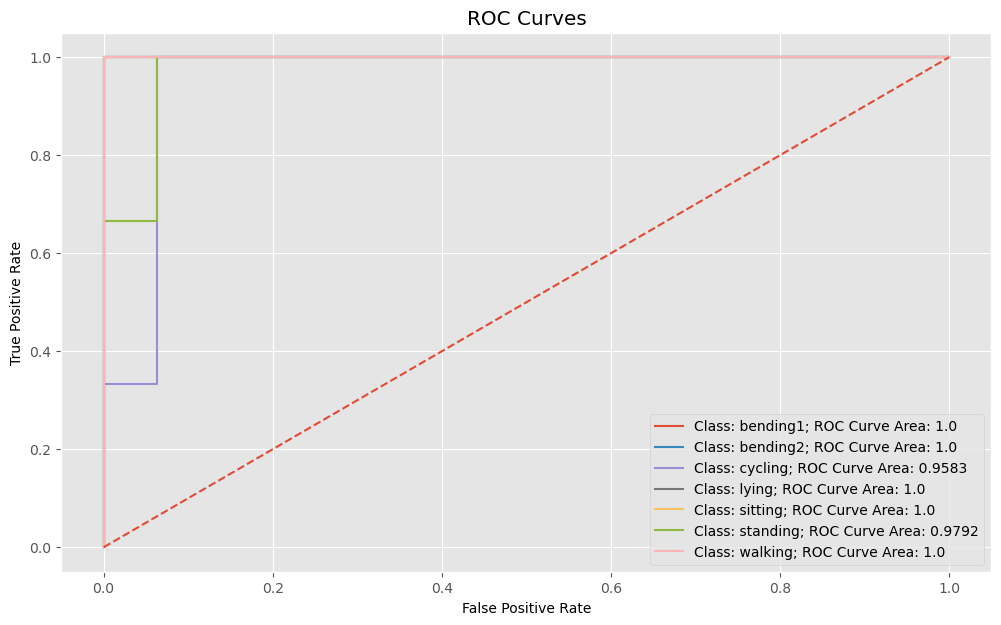

In [41]:
kwargs = { 'penalty' : 'l1', 'max_iter' : 100, 'multi_class' : 'multinomial', 'solver' : 'saga' }

print(f"Optimal L : {optimal_L}")
best_l = optimal_L

Regression_With_Classifier(LogisticRegression, "Logistic Regression",
                           best_l, kwargs, penalty='none', is_binary_classification=False, draw_roc=True)

### 2c-ii) Repeat 2(c)i using a Naive Bayes' classifier. Use both Gaussian and Multinomial priors and compare the results.

In [42]:
kwargs = {}

global optimal_L
optimal_L = 1

global max_test_accuracy
max_test_accuracy = 0

for l_val in range(1, 21):
    Regression_With_Classifier(GaussianNB, "Naive Bayes Classifier with Gaussian Prior",
                               l_val, kwargs, penalty='none', is_binary_classification=False, draw_roc=False)

Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

Running Naive Bayes Classifier with Gaussian Prior for l-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.6316
Value of L: 2 | train_error: 0.0 | test_error: 0.3684

Running Naive Bayes Classifier with Gaussian Prior for l-value 3
Value of L: 3 | train_score: 0.9855 | test_score: 0.7368
Value of L: 3 | train_error: 0.0145 | test_error: 0.2632

Running Naive Bayes Classifier with Gaussian Prior for l-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.7895
Value of L: 4 | train_error: 0.0 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 5
Value of L: 5 | train_score: 0.9855 | test_score: 0.7895
Value of L: 5 | train_error: 0.0145 | test_error: 0.2105

Running Naive Bayes Classifier with Gaussian Prior for l-value 6
Value of L: 6 | train_score: 0.971 | test_score: 0.63

Optimal L : 1
Running Naive Bayes Classifier with Gaussian Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


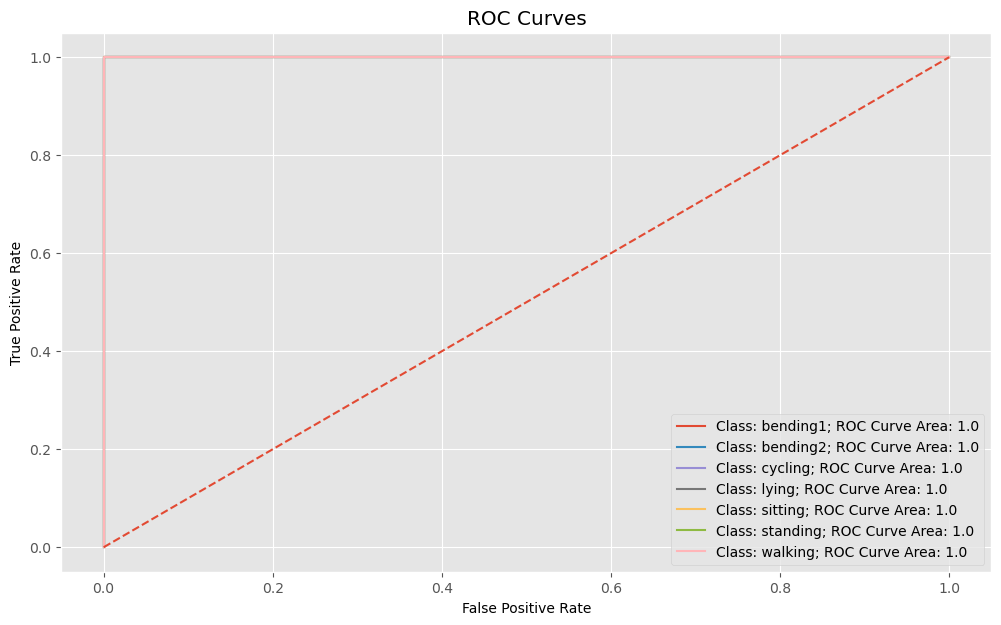

ROC Curve for Test Data


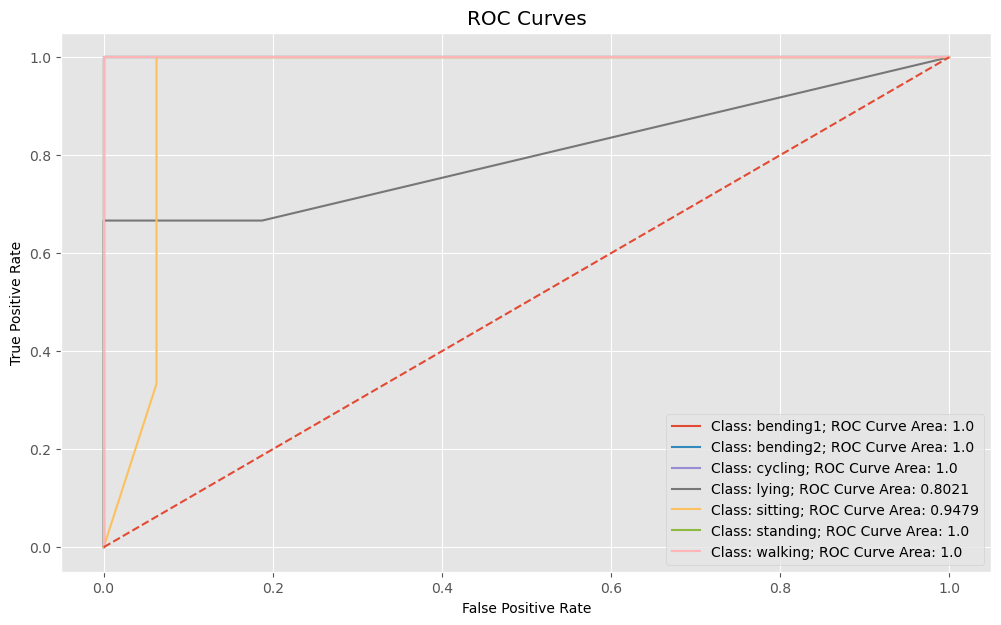

In [43]:
kwargs = {}

fold_count = 5
print(f"Optimal L : {optimal_L}")
best_l = optimal_L

Regression_With_Classifier(GaussianNB, "Naive Bayes Classifier with Gaussian Prior",
                                   best_l, kwargs, penalty='none', is_binary_classification=False, draw_roc=True)

In [44]:
kwargs = {}

global optimal_L
optimal_L = 1

global max_test_accuracy
max_test_accuracy = 0


for l_val in range(1, 21):
    Regression_With_Classifier(MultinomialNB, "Naive Bayes Classifier with Multinomial Prior",
                               l_val, kwargs, penalty='none', is_binary_classification=False, draw_roc=False)

Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Value of L: 1 | train_score: 0.9275 | test_score: 0.8947
Value of L: 1 | train_error: 0.0725 | test_error: 0.1053

Running Naive Bayes Classifier with Multinomial Prior for l-value 2
Value of L: 2 | train_score: 0.8841 | test_score: 0.7368
Value of L: 2 | train_error: 0.1159 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 3
Value of L: 3 | train_score: 0.8986 | test_score: 0.7895
Value of L: 3 | train_error: 0.1014 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.7895
Value of L: 4 | train_error: 0.087 | test_error: 0.2105

Running Naive Bayes Classifier with Multinomial Prior for l-value 5
Value of L: 5 | train_score: 0.9275 | test_score: 0.7368
Value of L: 5 | train_error: 0.0725 | test_error: 0.2632

Running Naive Bayes Classifier with Multinomial Prior for l-value 6
Value of L: 6 | tra

Optimal L : 1
Running Naive Bayes Classifier with Multinomial Prior for l-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


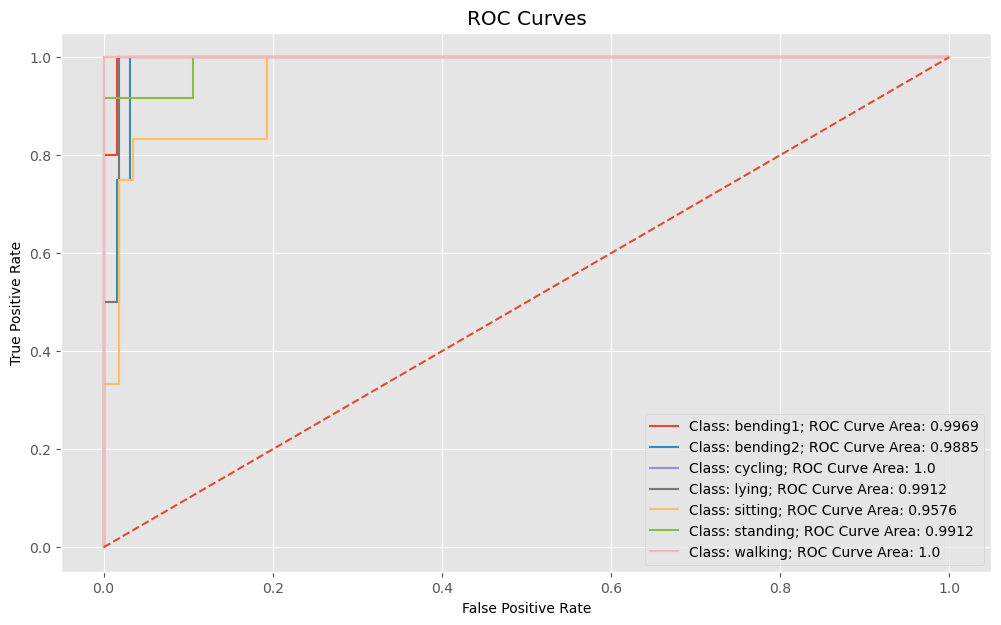

ROC Curve for Test Data


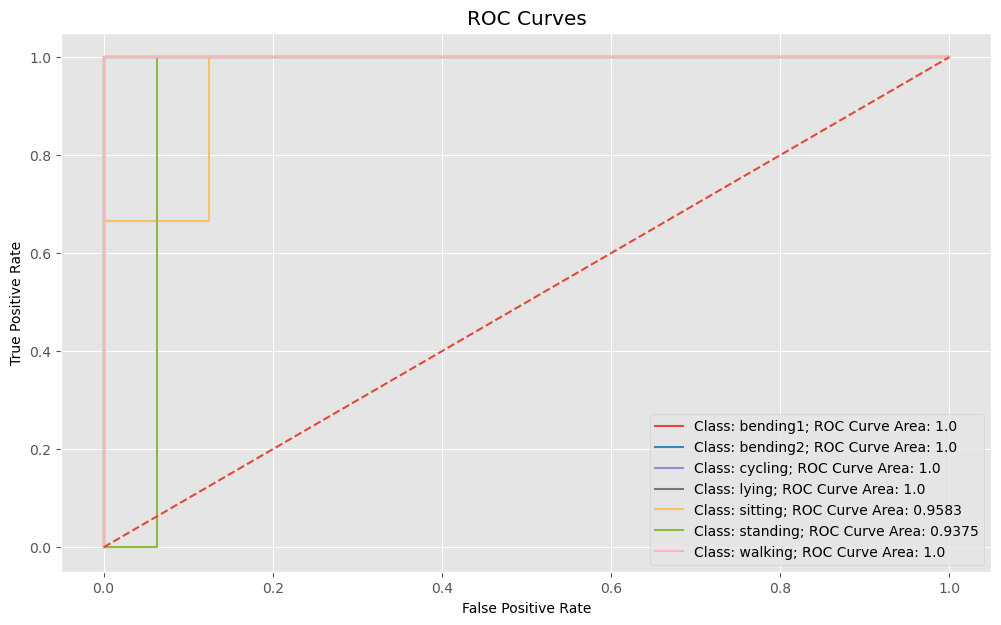

In [45]:
kwargs = {}

print(f"Optimal L : {optimal_L}")
best_l = optimal_L

# performing regression with the given classifier for the best value of L calculated from the above cell
Regression_With_Classifier(MultinomialNB, "Naive Bayes Classifier with Multinomial Prior",
                           best_l, kwargs, penalty='none', is_binary_classification=False, draw_roc=True)

### 2c-iii) Which method is better for multi-class classification in this problem?

##### We studied the below 3 classifiers w.r.t multi-class classification  -->

- Logistic Regression
- Naive Bayes Classifier with Gaussian Prior
- Naive Bayes Classifier with Multinomial Prior

*If we observe the confusion matrix of each of these classifiers, we see that the diagonal elements (from top-left to bottom-right) represent the number of correct predictions for each class, whereas, off-diagonal elements represent misclassifications. All of the three models have the same error rate on the test set (2 misclassified samples). However, we observe that logistic regression has a better ROC curve whose AUC are larger for all classes. Hence we conclude that the logistic regression has a relatively better classification performance for the given dataset.*

# 3) ISLR 4.8.3

**This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a classspecific mean vector and a class specific covariance matrix. We consider the simple case where p = 1; i.e. there is only one feature. Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal distribution, X ∼ N(μk, σ2k). Recall that the density function for the one-dimensional normal distribution is given in (4.11). Prove that in this case, the Bayes’ classifier is not linear. Argue that it is in fact quadratic.**

**Hint: For this problem, you should follow the arguments laid out in Section 4.4.2, but without making the assumption that σ21 = ... = σ2K.**

**ANSWER**

![](images/image4.8.3.jpg)

# 4) ISLR 4.8.7

**Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was $\bar{X}$ = 10, while the mean for those that didn’t was $\bar{X}$ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.**

**ANSWER**

In [53]:
import scipy.stats as stats

P_K_YES_X_4 = (0.8*stats.norm.pdf(4,loc=10,scale=6))/(0.8*stats.norm.pdf(4,loc=10,scale=6)
                                                      +0.2*stats.norm.pdf(4,loc=0,scale=6))
P_K_YES_X_4

0.7518524532975261

![](images/image4.8.7.jpg)